Import important parameter

In [1]:
inputsize =49
e = 0.1

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

In [5]:
num_levels = 2
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))

Linear = 0.5816456814395141


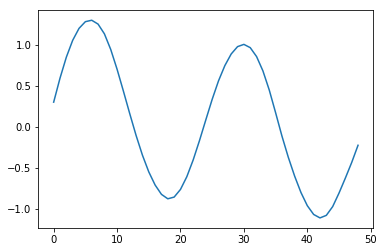

In [6]:
gmmx = linear_gmg.solve(RightF,np.zeros(A1.shape),tol=1e-12)
plt.plot(gmmx)

In [7]:
print("Relative error = {}".format(np.linalg.norm(gmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 0.24597798756199557


Local DMM on fine grid

In [8]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.6311843398005011
Iteration 200/4000
Upper bound estimation = 0.6184801366579954
Iteration 300/4000
Upper bound estimation = 0.6147460944887924
Iteration 400/4000
Upper bound estimation = 0.5990824552725864
Iteration 500/4000
Upper bound estimation = 0.5955282851984111
Iteration 600/4000
Upper bound estimation = 0.5759001910373504
Iteration 700/4000
Upper bound estimation = 0.5567426108114465
Iteration 800/4000
Upper bound estimation = 0.5559814143683292
Iteration 900/4000
Upper bound estimation = 0.5463454576101898
Iteration 1000/4000
Upper bound estimation = 0.5212285984033699
Iteration 1100/4000
Upper bound estimation = 0.5240502786339092
Iteration 1200/4000
Upper bound estimation = 0.5094095241944206
Iteration 1300/4000
Upper bound estimation = 0.49757178807754016
Iteration 1400/4000
Upper bound estimation = 0.4891657409140748
Iteration 1500/4000
Upper bound estimation = 0.46427092617727894
Iteration 1600/4000
Upper bound estimation = 0.

In [9]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.21484229209539443


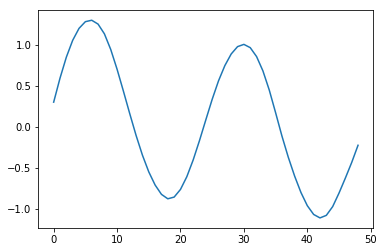

In [10]:
dmmx = deep_gmm.solve(RightF,np.zeros(A1.shape) ,tol=1e-12)
plt.plot(gmmx)

In [11]:
print("Relative error = {}".format(np.linalg.norm(dmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 0.24597798756204664


In [12]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.11912470442502118
L = 0.03
rho = 0.11932749867966881
L = 0.04
rho = 0.11963400773879379
L = 0.05
rho = 0.12001523464627348
L = 0.060000000000000005
rho = 0.12044758166884219
L = 0.07
rho = 0.12091447291101436
L = 0.08
rho = 0.12140537633906194
L = 0.09
rho = 0.12191411888040637
L = 0.09999999999999999
rho = 0.12243738101173102
L = 0.10999999999999999
rho = 0.1229735896305744
L = 0.11999999999999998
rho = 0.1235221661971305
L = 0.12999999999999998
rho = 0.1240830320117492
L = 0.13999999999999999
rho = 0.12465628730011075
L = 0.15
rho = 0.1252420076172374
L = 0.16
rho = 0.12584012229216224
L = 0.17
rho = 0.12645035266896262
L = 0.18000000000000002
rho = 0.12707219465106026
L = 0.19000000000000003
rho = 0.12770493312025197
L = 0.20000000000000004
rho = 0.12834767730206667
L = 0.21000000000000005
rho = 0.12899940742185487
L = 0.22000000000000006
rho = 0.12965902462360313
L = 0.23000000000000007
rho = 0.13032539813501842
L = 0.24000000000000007
rho = 0

the 31 steps
rho = 0.1751356120557354
the 32 steps
rho = 0.1751112416220745
the 33 steps
rho = 0.17508707099158535
the 34 steps
rho = 0.1750630978822467
the 35 steps
rho = 0.175039320008429
the 36 steps
rho = 0.1750157350819523
the 37 steps
rho = 0.17499234081314613
the 38 steps
rho = 0.1749691349118737
the 39 steps
rho = 0.17494611508855976
the 40 steps
rho = 0.1749232790551807
the 41 steps
rho = 0.17490062452625413
the 42 steps
rho = 0.17487814921979708
the 43 steps
rho = 0.17485585085826819
the 44 steps
rho = 0.17483372716949244
the 45 steps
rho = 0.1748117758875538
the 46 steps
rho = 0.1747899947536755
the 47 steps
rho = 0.17476838151707322
the 48 steps
rho = 0.17474693393578097
the 49 steps
rho = 0.174725649777464
the 50 steps
rho = 0.17470452682018697
the 51 steps
rho = 0.1746835628531841
the 52 steps
rho = 0.1746627556775779
the 53 steps
rho = 0.17464210310708986
the 54 steps
rho = 0.1746216029687198
the 55 steps
rho = 0.17460125310339808
the 56 steps
rho = 0.1745810513666087
th

the 201 steps
rho = 0.17247846167628134
the 202 steps
rho = 0.17246675510556694
the 203 steps
rho = 0.17245506777256014
the 204 steps
rho = 0.17244339953076854
the 205 steps
rho = 0.17243175023670443
the 206 steps
rho = 0.17242011974980223
the 207 steps
rho = 0.1724085079323526
the 208 steps
rho = 0.17239691464944387
the 209 steps
rho = 0.17238533976888373
the 210 steps
rho = 0.17237378316114615
the 211 steps
rho = 0.17236224469930372
the 212 steps
rho = 0.17235072425896936
the 213 steps
rho = 0.17233922171823388
the 214 steps
rho = 0.1723277369576123
the 215 steps
rho = 0.17231626985997778
the 216 steps
rho = 0.17230482031051775
the 217 steps
rho = 0.17229338819667014
the 218 steps
rho = 0.17228197340807386
the 219 steps
rho = 0.17227057583651617
the 220 steps
rho = 0.17225919537588247
the 221 steps
rho = 0.17224783192210313
the 222 steps
rho = 0.17223648537311087
the 223 steps
rho = 0.1722251556287853
the 224 steps
rho = 0.17221384259091838
the 225 steps
rho = 0.17220254616315223
the

the 349 steps
rho = 0.17091061128359025
the 350 steps
rho = 0.170900962856089
the 351 steps
rho = 0.17089132551881672
the 352 steps
rho = 0.17088169924866056
the 353 steps
rho = 0.17087208402262558
the 354 steps
rho = 0.1708624798178254
the 355 steps
rho = 0.17085288661148623
the 356 steps
rho = 0.1708433043809442
the 357 steps
rho = 0.17083373310364075
the 358 steps
rho = 0.1708241727571249
the 359 steps
rho = 0.17081462331904776
the 360 steps
rho = 0.17080508476716744
the 361 steps
rho = 0.17079555707934116
the 362 steps
rho = 0.17078604023352878
the 363 steps
rho = 0.17077653420778766
the 364 steps
rho = 0.1707670389802732
the 365 steps
rho = 0.17075755452924016
the 366 steps
rho = 0.17074808083303492
the 367 steps
rho = 0.17073861787010167
the 368 steps
rho = 0.17072916561897764
the 369 steps
rho = 0.17071972405828995
the 370 steps
rho = 0.1707102931667602
the 371 steps
rho = 0.17070087292319575
the 372 steps
rho = 0.1706914633065004
the 373 steps
rho = 0.17068206429565996
the 374 

the 505 steps
rho = 0.16952719799933375
the 506 steps
rho = 0.16951904980140825
the 507 steps
rho = 0.16951090997629176
the 508 steps
rho = 0.16950277851072473
the 509 steps
rho = 0.16949465539148934
the 510 steps
rho = 0.169486540605405
the 511 steps
rho = 0.1694784341393397
the 512 steps
rho = 0.1694703359801881
the 513 steps
rho = 0.16946224611489924
the 514 steps
rho = 0.16945416453045206
the 515 steps
rho = 0.16944609121386864
the 516 steps
rho = 0.1694380261522098
the 517 steps
rho = 0.16942996933257667
the 518 steps
rho = 0.16942192074210657
the 519 steps
rho = 0.16941388036797791
the 520 steps
rho = 0.16940584819740764
the 521 steps
rho = 0.16939782421765154
the 522 steps
rho = 0.16938980841600193
the 523 steps
rho = 0.16938180077979062
the 524 steps
rho = 0.16937380129638688
the 525 steps
rho = 0.16936580995319708
the 526 steps
rho = 0.1693578267376653
the 527 steps
rho = 0.1693498516372762
the 528 steps
rho = 0.16934188463954702
the 529 steps
rho = 0.16933392573203462
the 530

the 663 steps
rho = 0.16833596048251628
the 664 steps
rho = 0.1683289926387382
the 665 steps
rho = 0.16832203146789199
the 666 steps
rho = 0.16831507696111955
the 667 steps
rho = 0.1683081291095779
the 668 steps
rho = 0.16830118790444182
the 669 steps
rho = 0.1682942533369013
the 670 steps
rho = 0.1682873253981664
the 671 steps
rho = 0.1682804040794579
the 672 steps
rho = 0.1682734893720195
the 673 steps
rho = 0.1682665812671065
the 674 steps
rho = 0.16825967975599201
the 675 steps
rho = 0.1682527848299677
the 676 steps
rho = 0.1682458964803377
the 677 steps
rho = 0.1682390146984225
the 678 steps
rho = 0.1682321394755595
the 679 steps
rho = 0.16822527080310237
the 680 steps
rho = 0.16821840867241794
the 681 steps
rho = 0.1682115530748927
the 682 steps
rho = 0.16820470400192444
the 683 steps
rho = 0.1681978614449273
the 684 steps
rho = 0.1681910253953342
the 685 steps
rho = 0.1681841958445864
the 686 steps
rho = 0.16817737278414666
the 687 steps
rho = 0.16817055620548876
the 688 steps
r

the 829 steps
rho = 0.16726447910263642
the 830 steps
rho = 0.16725850765529857
the 831 steps
rho = 0.16725254158019115
the 832 steps
rho = 0.16724658087023106
the 833 steps
rho = 0.16724062551833926
the 834 steps
rho = 0.16723467551744742
the 835 steps
rho = 0.16722873086049073
the 836 steps
rho = 0.16722279154041128
the 837 steps
rho = 0.16721685755016
the 838 steps
rho = 0.16721092888269137
the 839 steps
rho = 0.16720500553096698
the 840 steps
rho = 0.16719908748795761
the 841 steps
rho = 0.16719317474663714
the 842 steps
rho = 0.16718726729998692
the 843 steps
rho = 0.16718136514099652
the 844 steps
rho = 0.1671754682626568
the 845 steps
rho = 0.1671695766579733
the 846 steps
rho = 0.16716369031995015
the 847 steps
rho = 0.16715780924160092
the 848 steps
rho = 0.16715193341594597
the 849 steps
rho = 0.16714606283601102
the 850 steps
rho = 0.1671401974948288
the 851 steps
rho = 0.16713433738543704
the 852 steps
rho = 0.16712848250088136
the 853 steps
rho = 0.1671226328342122
the 854

the 982 steps
rho = 0.16640930400775522
the 983 steps
rho = 0.16640407566233087
the 984 steps
rho = 0.16639885167385002
the 985 steps
rho = 0.16639363203610721
the 986 steps
rho = 0.16638841674290042
the 987 steps
rho = 0.16638320578803406
the 988 steps
rho = 0.16637799916531526
the 989 steps
rho = 0.16637279686856377
the 990 steps
rho = 0.16636759889159697
the 991 steps
rho = 0.16636240522824022
the 992 steps
rho = 0.1663572158723289
the 993 steps
rho = 0.16635203081769764
the 994 steps
rho = 0.16634685005819064
the 995 steps
rho = 0.1663416735876573
the 996 steps
rho = 0.16633650139995074
the 997 steps
rho = 0.16633133348893292
the 998 steps
rho = 0.16632616984846793
the 999 steps
rho = 0.16632101047242756
the 1000 steps
rho = 0.16631585535468857
the 1001 steps
rho = 0.16631070448913388
the 1002 steps
rho = 0.16630555786965268
the 1003 steps
rho = 0.16630041549013808
the 1004 steps
rho = 0.1662952773444901
the 1005 steps
rho = 0.16629014342661416
the 1006 steps
rho = 0.16628501373042

the 1150 steps
rho = 0.16558742871658727
the 1151 steps
rho = 0.16558284981368465
the 1152 steps
rho = 0.16557827430867955
the 1153 steps
rho = 0.16557370219640316
the 1154 steps
rho = 0.16556913347169608
the 1155 steps
rho = 0.16556456812940465
the 1156 steps
rho = 0.1655600061643811
the 1157 steps
rho = 0.16555544757148624
the 1158 steps
rho = 0.16555089234558684
the 1159 steps
rho = 0.1655463404815558
the 1160 steps
rho = 0.16554179197427366
the 1161 steps
rho = 0.16553724681862853
the 1162 steps
rho = 0.16553270500951445
the 1163 steps
rho = 0.16552816654183078
the 1164 steps
rho = 0.1655236314104872
the 1165 steps
rho = 0.16551909961039837
the 1166 steps
rho = 0.16551457113648468
the 1167 steps
rho = 0.16551004598367586
the 1168 steps
rho = 0.16550552414690795
the 1169 steps
rho = 0.16550100562112188
the 1170 steps
rho = 0.16549649040126704
the 1171 steps
rho = 0.16549197848230202
the 1172 steps
rho = 0.16548746985918714
the 1173 steps
rho = 0.16548296452689312
the 1174 steps
rho 

the 1320 steps
rho = 0.1648539031464383
the 1321 steps
rho = 0.16484983328081457
the 1322 steps
rho = 0.16484576603551793
the 1323 steps
rho = 0.16484170140657828
the 1324 steps
rho = 0.1648376393900356
the 1325 steps
rho = 0.16483357998193587
the 1326 steps
rho = 0.16482952317833235
the 1327 steps
rho = 0.1648254689752867
the 1328 steps
rho = 0.16482141736886383
the 1329 steps
rho = 0.16481736835513902
the 1330 steps
rho = 0.16481332193019377
the 1331 steps
rho = 0.164809278090115
the 1332 steps
rho = 0.1648052368309993
the 1333 steps
rho = 0.1648011981489477
the 1334 steps
rho = 0.16479716204006992
the 1335 steps
rho = 0.16479312850048175
the 1336 steps
rho = 0.16478909752630605
the 1337 steps
rho = 0.16478506911367227
the 1338 steps
rho = 0.16478104325871903
the 1339 steps
rho = 0.16477701995758812
the 1340 steps
rho = 0.16477299920643101
the 1341 steps
rho = 0.16476898100140708
the 1342 steps
rho = 0.16476496533867943
the 1343 steps
rho = 0.16476095221441853
the 1344 steps
rho = 0.

the 1497 steps
rho = 0.1641710158846003
the 1498 steps
rho = 0.1641673541667836
the 1499 steps
rho = 0.1641636944708754
the 1500 steps
rho = 0.16416003679404903
the 1501 steps
rho = 0.1641563811334821
the 1502 steps
rho = 0.1641527274863623
the 1503 steps
rho = 0.16414907584987773
the 1504 steps
rho = 0.16414542622122558
the 1505 steps
rho = 0.16414177859760687
the 1506 steps
rho = 0.16413813297622992
the 1507 steps
rho = 0.16413448935430713
the 1508 steps
rho = 0.16413084772905745
the 1509 steps
rho = 0.16412720809770598
the 1510 steps
rho = 0.16412357045748122
the 1511 steps
rho = 0.1641199348056206
the 1512 steps
rho = 0.16411630113936349
the 1513 steps
rho = 0.1641126694559577
the 1514 steps
rho = 0.1641090397526553
the 1515 steps
rho = 0.1641054120267143
the 1516 steps
rho = 0.16410178627539765
the 1517 steps
rho = 0.1640981624959745
the 1518 steps
rho = 0.16409454068571944
the 1519 steps
rho = 0.16409092084191368
the 1520 steps
rho = 0.16408730296184076
the 1521 steps
rho = 0.164

the 1666 steps
rho = 0.16357883112066637
the 1667 steps
rho = 0.16357547515825743
the 1668 steps
rho = 0.16357212081311964
the 1669 steps
rho = 0.16356876808324614
the 1670 steps
rho = 0.16356541696663837
the 1671 steps
rho = 0.1635620674612987
the 1672 steps
rho = 0.16355871956523446
the 1673 steps
rho = 0.16355537327645572
the 1674 steps
rho = 0.16355202859297885
the 1675 steps
rho = 0.16354868551282317
the 1676 steps
rho = 0.16354534403401164
the 1677 steps
rho = 0.1635420041545716
the 1678 steps
rho = 0.16353866587253216
the 1679 steps
rho = 0.16353532918593014
the 1680 steps
rho = 0.16353199409280392
the 1681 steps
rho = 0.1635286605911966
the 1682 steps
rho = 0.16352532867915515
the 1683 steps
rho = 0.16352199835472941
the 1684 steps
rho = 0.1635186696159754
the 1685 steps
rho = 0.16351534246094884
the 1686 steps
rho = 0.1635120168877143
the 1687 steps
rho = 0.1635086928943361
the 1688 steps
rho = 0.1635053704788861
the 1689 steps
rho = 0.16350204963943707
the 1690 steps
rho = 0.

the 1804 steps
rho = 0.163130191846032
the 1805 steps
rho = 0.16312704170742037
the 1806 steps
rho = 0.1631238929435832
the 1807 steps
rho = 0.16312074555298714
the 1808 steps
rho = 0.16311759953410163
the 1809 steps
rho = 0.16311445488539963
the 1810 steps
rho = 0.16311131160535636
the 1811 steps
rho = 0.16310816969244976
the 1812 steps
rho = 0.1631050291451639
the 1813 steps
rho = 0.1631018899619788
the 1814 steps
rho = 0.16309875214138383
the 1815 steps
rho = 0.16309561568186792
the 1816 steps
rho = 0.16309248058192272
the 1817 steps
rho = 0.1630893468400451
the 1818 steps
rho = 0.1630862144547319
the 1819 steps
rho = 0.16308308342448383
the 1820 steps
rho = 0.1630799537478053
the 1821 steps
rho = 0.16307682542320182
the 1822 steps
rho = 0.16307369844918368
the 1823 steps
rho = 0.16307057282426093
the 1824 steps
rho = 0.16306744854694957
the 1825 steps
rho = 0.16306432561576623
the 1826 steps
rho = 0.16306120402923185
the 1827 steps
rho = 0.16305808378586872
the 1828 steps
rho = 0.1

the 1983 steps
rho = 0.1625868860380366
the 1984 steps
rho = 0.1625839599723331
the 1985 steps
rho = 0.16258103504640836
the 1986 steps
rho = 0.16257811125914137
the 1987 steps
rho = 0.16257518860941408
the 1988 steps
rho = 0.1625722670961069
the 1989 steps
rho = 0.16256934671810555
the 1990 steps
rho = 0.1625664274742961
the 1991 steps
rho = 0.16256350936356587
the 1992 steps
rho = 0.16256059238480589
the 1993 steps
rho = 0.1625576765369063
the 1994 steps
rho = 0.1625547618187614
the 1995 steps
rho = 0.16255184822926755
the 1996 steps
rho = 0.1625489357673197
the 1997 steps
rho = 0.16254602443181748
the 1998 steps
rho = 0.1625431142216612
the 1999 steps
rho = 0.16254020513575332
the 2000 steps
rho = 0.1625372971729981
the 2001 steps
rho = 0.16253439033230252
the 2002 steps
rho = 0.16253148461257108
the 2003 steps
rho = 0.1625285800127164
the 2004 steps
rho = 0.16252567653164784
the 2005 steps
rho = 0.1625227741682791
the 2006 steps
rho = 0.16251987292152456
the 2007 steps
rho = 0.1625

the 2142 steps
rho = 0.16213526503966474
the 2143 steps
rho = 0.16213250721639647
the 2144 steps
rho = 0.16212975037506436
the 2145 steps
rho = 0.16212699451479454
the 2146 steps
rho = 0.162124239634709
the 2147 steps
rho = 0.1621214857339346
the 2148 steps
rho = 0.16211873281159808
the 2149 steps
rho = 0.1621159808668264
the 2150 steps
rho = 0.16211322989874982
the 2151 steps
rho = 0.16211047990649838
the 2152 steps
rho = 0.16210773088920474
the 2153 steps
rho = 0.16210498284600147
the 2154 steps
rho = 0.16210223577602298
the 2155 steps
rho = 0.16209948967840557
the 2156 steps
rho = 0.16209674455228504
the 2157 steps
rho = 0.16209400039679855
the 2158 steps
rho = 0.16209125721108933
the 2159 steps
rho = 0.16208851499429405
the 2160 steps
rho = 0.1620857737455589
the 2161 steps
rho = 0.16208303346402206
the 2162 steps
rho = 0.1620802941488312
the 2163 steps
rho = 0.16207755579913158
the 2164 steps
rho = 0.16207481841407004
the 2165 steps
rho = 0.16207208199279355
the 2166 steps
rho = 0

the 2318 steps
rho = 0.161664273122793
the 2319 steps
rho = 0.16166167567262016
the 2320 steps
rho = 0.16165907906780536
the 2321 steps
rho = 0.16165648330766352
the 2322 steps
rho = 0.1616538883915127
the 2323 steps
rho = 0.16165129431867137
the 2324 steps
rho = 0.16164870108845572
the 2325 steps
rho = 0.16164610870018736
the 2326 steps
rho = 0.16164351715318614
the 2327 steps
rho = 0.16164092644677458
the 2328 steps
rho = 0.16163833658027488
the 2329 steps
rho = 0.16163574755300883
the 2330 steps
rho = 0.16163315936430206
the 2331 steps
rho = 0.16163057201348024
the 2332 steps
rho = 0.16162798549986762
the 2333 steps
rho = 0.16162539982279228
the 2334 steps
rho = 0.16162281498158362
the 2335 steps
rho = 0.16162023097556855
the 2336 steps
rho = 0.16161764780407747
the 2337 steps
rho = 0.16161506546644014
the 2338 steps
rho = 0.16161248396199102
the 2339 steps
rho = 0.16160990329006011
the 2340 steps
rho = 0.16160732344998052
the 2341 steps
rho = 0.16160474444108852
the 2342 steps
rho 

the 2457 steps
rho = 0.16131104910988328
the 2458 steps
rho = 0.16130856299198568
the 2459 steps
rho = 0.1613060776327179
the 2460 steps
rho = 0.16130359303151087
the 2461 steps
rho = 0.16130110918779977
the 2462 steps
rho = 0.16129862610101817
the 2463 steps
rho = 0.16129614377060114
the 2464 steps
rho = 0.1612936621959837
the 2465 steps
rho = 0.16129118137660395
the 2466 steps
rho = 0.16128870131189751
the 2467 steps
rho = 0.161286222001306
the 2468 steps
rho = 0.1612837434442633
the 2469 steps
rho = 0.16128126564021136
the 2470 steps
rho = 0.16127878858859204
the 2471 steps
rho = 0.16127631228884398
the 2472 steps
rho = 0.16127383674040965
the 2473 steps
rho = 0.16127136194273242
the 2474 steps
rho = 0.16126888789525504
the 2475 steps
rho = 0.16126641459742114
the 2476 steps
rho = 0.16126394204867545
the 2477 steps
rho = 0.1612614702484638
the 2478 steps
rho = 0.1612589991962326
the 2479 steps
rho = 0.16125652889142908
the 2480 steps
rho = 0.16125405933350048
the 2481 steps
rho = 0.

the 2604 steps
rho = 0.16095344994933455
the 2605 steps
rho = 0.1609510696344693
the 2606 steps
rho = 0.16094869000239806
the 2607 steps
rho = 0.16094631105265103
the 2608 steps
rho = 0.1609439327847615
the 2609 steps
rho = 0.16094155519826409
the 2610 steps
rho = 0.16093917829269344
the 2611 steps
rho = 0.16093680206758343
the 2612 steps
rho = 0.1609344265224693
the 2613 steps
rho = 0.16093205165688781
the 2614 steps
rho = 0.16092967747037537
the 2615 steps
rho = 0.1609273039624684
the 2616 steps
rho = 0.16092493113270717
the 2617 steps
rho = 0.16092255898062752
the 2618 steps
rho = 0.16092018750576906
the 2619 steps
rho = 0.16091781670767272
the 2620 steps
rho = 0.16091544658587825
the 2621 steps
rho = 0.160913077139924
the 2622 steps
rho = 0.16091070836935525
the 2623 steps
rho = 0.1609083402737122
the 2624 steps
rho = 0.16090597285253724
the 2625 steps
rho = 0.16090360610537352
the 2626 steps
rho = 0.16090124003176534
the 2627 steps
rho = 0.1608988746312566
the 2628 steps
rho = 0.1

the 2746 steps
rho = 0.16062207166755915
the 2747 steps
rho = 0.16061978389690057
the 2748 steps
rho = 0.16061749674829015
the 2749 steps
rho = 0.1606152102213374
the 2750 steps
rho = 0.16061292431565374
the 2751 steps
rho = 0.1606106390308491
the 2752 steps
rho = 0.16060835436653473
the 2753 steps
rho = 0.16060607032232224
the 2754 steps
rho = 0.16060378689782415
the 2755 steps
rho = 0.16060150409265236
the 2756 steps
rho = 0.16059922190642076
the 2757 steps
rho = 0.1605969403387433
the 2758 steps
rho = 0.16059465938923256
the 2759 steps
rho = 0.16059237905750431
the 2760 steps
rho = 0.16059009934317225
the 2761 steps
rho = 0.1605878202458541
the 2762 steps
rho = 0.16058554176516304
the 2763 steps
rho = 0.16058326390071853
the 2764 steps
rho = 0.16058098665213605
the 2765 steps
rho = 0.16057871001903085
the 2766 steps
rho = 0.1605764340010253
the 2767 steps
rho = 0.1605741585977341
the 2768 steps
rho = 0.16057188380877765
the 2769 steps
rho = 0.16056960963377415
the 2770 steps
rho = 0

the 2891 steps
rho = 0.1602966530892869
the 2892 steps
rho = 0.16029445166940906
the 2893 steps
rho = 0.1602922508196837
the 2894 steps
rho = 0.16029005053978498
the 2895 steps
rho = 0.16028785082938377
the 2896 steps
rho = 0.16028565168815523
the 2897 steps
rho = 0.16028345311577175
the 2898 steps
rho = 0.1602812551119069
the 2899 steps
rho = 0.1602790576762367
the 2900 steps
rho = 0.16027686080843354
the 2901 steps
rho = 0.16027466450817357
the 2902 steps
rho = 0.16027246877513193
the 2903 steps
rho = 0.16027027360898505
the 2904 steps
rho = 0.16026807900940812
the 2905 steps
rho = 0.16026588497607794
the 2906 steps
rho = 0.1602636915086728
the 2907 steps
rho = 0.1602614986068679
the 2908 steps
rho = 0.16025930627034254
the 2909 steps
rho = 0.1602571144987739
the 2910 steps
rho = 0.1602549232918397
the 2911 steps
rho = 0.16025273264922119
the 2912 steps
rho = 0.16025054257059468
the 2913 steps
rho = 0.16024835305564164
the 2914 steps
rho = 0.16024616410404038
the 2915 steps
rho = 0.1

the 3041 steps
rho = 0.15997263829849578
the 3042 steps
rho = 0.1599705189376968
the 3043 steps
rho = 0.159968400101819
the 3044 steps
rho = 0.15996628179058542
the 3045 steps
rho = 0.15996416400371993
the 3046 steps
rho = 0.159962046740944
the 3047 steps
rho = 0.1599599300019826
the 3048 steps
rho = 0.15995781378655816
the 3049 steps
rho = 0.1599556980943954
the 3050 steps
rho = 0.15995358292521886
the 3051 steps
rho = 0.15995146827875267
the 3052 steps
rho = 0.15994935415472197
the 3053 steps
rho = 0.15994724055285284
the 3054 steps
rho = 0.1599451274728695
the 3055 steps
rho = 0.15994301491449897
the 3056 steps
rho = 0.1599409028774654
the 3057 steps
rho = 0.15993879136149666
the 3058 steps
rho = 0.15993668036631986
the 3059 steps
rho = 0.15993456989166077
the 3060 steps
rho = 0.15993245993724647
the 3061 steps
rho = 0.15993035050280527
the 3062 steps
rho = 0.15992824158806485
the 3063 steps
rho = 0.15992613319275284
the 3064 steps
rho = 0.15992402531659697
the 3065 steps
rho = 0.15

the 3194 steps
rho = 0.15965432358990228
the 3195 steps
rho = 0.159652281475843
the 3196 steps
rho = 0.15965023984735566
the 3197 steps
rho = 0.15964819870420022
the 3198 steps
rho = 0.1596461580461396
the 3199 steps
rho = 0.15964411787293623
the 3200 steps
rho = 0.1596420781843514
the 3201 steps
rho = 0.1596400389801473
the 3202 steps
rho = 0.1596380002600867
the 3203 steps
rho = 0.15963596202393215
the 3204 steps
rho = 0.15963392427144768
the 3205 steps
rho = 0.15963188700239261
the 3206 steps
rho = 0.15962985021653542
the 3207 steps
rho = 0.15962781391363665
the 3208 steps
rho = 0.1596257780934612
the 3209 steps
rho = 0.1596237427557719
the 3210 steps
rho = 0.15962170790033547
the 3211 steps
rho = 0.15961967352691311
the 3212 steps
rho = 0.1596176396352726
the 3213 steps
rho = 0.15961560622517643
the 3214 steps
rho = 0.1596135732963903
the 3215 steps
rho = 0.1596115408486799
the 3216 steps
rho = 0.15960950888181055
the 3217 steps
rho = 0.15960747739554806
the 3218 steps
rho = 0.1596

the 3346 steps
rho = 0.15934936220284596
the 3347 steps
rho = 0.15934739127496134
the 3348 steps
rho = 0.15934542079867572
the 3349 steps
rho = 0.15934345077377884
the 3350 steps
rho = 0.15934148120006153
the 3351 steps
rho = 0.15933951207731634
the 3352 steps
rho = 0.15933754340533213
the 3353 steps
rho = 0.15933557518390018
the 3354 steps
rho = 0.1593336074128129
the 3355 steps
rho = 0.1593316400918605
the 3356 steps
rho = 0.15932967322083594
the 3357 steps
rho = 0.15932770679952948
the 3358 steps
rho = 0.15932574082773301
the 3359 steps
rho = 0.15932377530523975
the 3360 steps
rho = 0.15932181023184114
the 3361 steps
rho = 0.15931984560732923
the 3362 steps
rho = 0.1593178814314969
the 3363 steps
rho = 0.15931591770413686
the 3364 steps
rho = 0.15931395442504306
the 3365 steps
rho = 0.15931199159400752
the 3366 steps
rho = 0.15931002921082127
the 3367 steps
rho = 0.159308067275282
the 3368 steps
rho = 0.1593061057871803
the 3369 steps
rho = 0.15930414474630994
the 3370 steps
rho = 0

the 3492 steps
rho = 0.15906628327284816
the 3493 steps
rho = 0.15906437613875918
the 3494 steps
rho = 0.15906246942727784
the 3495 steps
rho = 0.15906056313821718
the 3496 steps
rho = 0.1590586572713872
the 3497 steps
rho = 0.1590567518266013
the 3498 steps
rho = 0.15905484680367019
the 3499 steps
rho = 0.15905294220240865
the 3500 steps
rho = 0.15905103802262666
the 3501 steps
rho = 0.1590491342641375
the 3502 steps
rho = 0.15904723092675346
the 3503 steps
rho = 0.15904532801028817
the 3504 steps
rho = 0.1590434255145535
the 3505 steps
rho = 0.1590415234393622
the 3506 steps
rho = 0.159039621784529
the 3507 steps
rho = 0.15903772054986676
the 3508 steps
rho = 0.15903581973518705
the 3509 steps
rho = 0.15903391934030456
the 3510 steps
rho = 0.15903201936503286
the 3511 steps
rho = 0.15903011980918624
the 3512 steps
rho = 0.15902822067257794
the 3513 steps
rho = 0.1590263219550222
the 3514 steps
rho = 0.15902442365633324
the 3515 steps
rho = 0.15902252577632459
the 3516 steps
rho = 0.1

the 3667 steps
rho = 0.1587388083174313
the 3668 steps
rho = 0.1587369723790113
the 3669 steps
rho = 0.15873513683204746
the 3670 steps
rho = 0.15873330167637145
the 3671 steps
rho = 0.15873146691181614
the 3672 steps
rho = 0.1587296325382119
the 3673 steps
rho = 0.15872779855539124
the 3674 steps
rho = 0.15872596496318575
the 3675 steps
rho = 0.15872413176142858
the 3676 steps
rho = 0.158722298949951
the 3677 steps
rho = 0.158720466528585
the 3678 steps
rho = 0.15871863449716286
the 3679 steps
rho = 0.15871680285551787
the 3680 steps
rho = 0.1587149716034817
the 3681 steps
rho = 0.15871314074088855
the 3682 steps
rho = 0.15871131026756957
the 3683 steps
rho = 0.1587094801833581
the 3684 steps
rho = 0.15870765048808716
the 3685 steps
rho = 0.15870582118159018
the 3686 steps
rho = 0.1587039922637
the 3687 steps
rho = 0.15870216373424928
the 3688 steps
rho = 0.15870033559307145
the 3689 steps
rho = 0.1586985078400019
the 3690 steps
rho = 0.15869668047487243
the 3691 steps
rho = 0.1586948

the 3804 steps
rho = 0.15849086231831824
the 3805 steps
rho = 0.15848907848079677
the 3806 steps
rho = 0.1584872950125444
the 3807 steps
rho = 0.1584855119134067
the 3808 steps
rho = 0.158483729183228
the 3809 steps
rho = 0.15848194682185227
the 3810 steps
rho = 0.1584801648291238
the 3811 steps
rho = 0.15847838320488902
the 3812 steps
rho = 0.15847660194899044
the 3813 steps
rho = 0.15847482106127497
the 3814 steps
rho = 0.15847304054158606
the 3815 steps
rho = 0.15847126038976955
the 3816 steps
rho = 0.1584694806056709
the 3817 steps
rho = 0.15846770118913375
the 3818 steps
rho = 0.15846592214000424
the 3819 steps
rho = 0.15846414345812884
the 3820 steps
rho = 0.1584623651433505
the 3821 steps
rho = 0.15846058719551775
the 3822 steps
rho = 0.15845880961447406
the 3823 steps
rho = 0.15845703240006542
the 3824 steps
rho = 0.15845525555213924
the 3825 steps
rho = 0.1584534790705399
the 3826 steps
rho = 0.15845170295511335
the 3827 steps
rho = 0.15844992720570633
the 3828 steps
rho = 0.1

the 3974 steps
rho = 0.15819279212910167
the 3975 steps
rho = 0.15819106889916895
the 3976 steps
rho = 0.15818934601324333
the 3977 steps
rho = 0.15818762347118118
the 3978 steps
rho = 0.1581859012728422
the 3979 steps
rho = 0.15818417941808258
the 3980 steps
rho = 0.15818245790676425
the 3981 steps
rho = 0.15818073673874203
the 3982 steps
rho = 0.1581790159138781
the 3983 steps
rho = 0.15817729543202935
the 3984 steps
rho = 0.15817557529305376
the 3985 steps
rho = 0.15817385549681207
the 3986 steps
rho = 0.15817213604316216
the 3987 steps
rho = 0.15817041693196252
the 3988 steps
rho = 0.15816869816307436
the 3989 steps
rho = 0.15816697973635366
the 3990 steps
rho = 0.15816526165166306
the 3991 steps
rho = 0.15816354390885987
the 3992 steps
rho = 0.15816182650780508
the 3993 steps
rho = 0.15816010944835532
the 3994 steps
rho = 0.15815839273037302
the 3995 steps
rho = 0.1581566763537164
the 3996 steps
rho = 0.15815496031824558
the 3997 steps
rho = 0.15815324462382077
the 3998 steps
rho 

the 4148 steps
rho = 0.15789800826678238
the 4149 steps
rho = 0.157896342826393
the 4150 steps
rho = 0.15789467770648943
the 4151 steps
rho = 0.15789301290694346
the 4152 steps
rho = 0.1578913484276252
the 4153 steps
rho = 0.15788968426840716
the 4154 steps
rho = 0.15788802042916067
the 4155 steps
rho = 0.15788635690975658
the 4156 steps
rho = 0.15788469371006833
the 4157 steps
rho = 0.15788303082996608
the 4158 steps
rho = 0.15788136826932264
the 4159 steps
rho = 0.15787970602800933
the 4160 steps
rho = 0.15787804410589873
the 4161 steps
rho = 0.15787638250286223
the 4162 steps
rho = 0.15787472121877272
the 4163 steps
rho = 0.15787306025350162
the 4164 steps
rho = 0.157871399606921
the 4165 steps
rho = 0.15786973927890452
the 4166 steps
rho = 0.15786807926932406
the 4167 steps
rho = 0.1578664195780522
the 4168 steps
rho = 0.15786476020496104
the 4169 steps
rho = 0.15786310114992344
the 4170 steps
rho = 0.1578614424128123
the 4171 steps
rho = 0.1578597839935005
the 4172 steps
rho = 0.1

the 4317 steps
rho = 0.1576209991693974
the 4318 steps
rho = 0.1576193861220471
the 4319 steps
rho = 0.15761777337446747
the 4320 steps
rho = 0.1576161609265434
the 4321 steps
rho = 0.15761454877815773
the 4322 steps
rho = 0.15761293692919262
the 4323 steps
rho = 0.15761132537953385
the 4324 steps
rho = 0.15760971412906516
the 4325 steps
rho = 0.15760810317766996
the 4326 steps
rho = 0.15760649252523035
the 4327 steps
rho = 0.15760488217163393
the 4328 steps
rho = 0.15760327211676173
the 4329 steps
rho = 0.15760166236049963
the 4330 steps
rho = 0.15760005290273157
the 4331 steps
rho = 0.15759844374334137
the 4332 steps
rho = 0.15759683488221413
the 4333 steps
rho = 0.1575952263192351
the 4334 steps
rho = 0.15759361805428546
the 4335 steps
rho = 0.1575920100872526
the 4336 steps
rho = 0.15759040241802177
the 4337 steps
rho = 0.15758879504647563
the 4338 steps
rho = 0.15758718797249965
the 4339 steps
rho = 0.15758558119597965
the 4340 steps
rho = 0.15758397471679883
the 4341 steps
rho = 

the 4467 steps
rho = 0.15738232924196222
the 4468 steps
rho = 0.1573807598979437
the 4469 steps
rho = 0.15737919083702126
the 4470 steps
rho = 0.15737762205908534
the 4471 steps
rho = 0.1573760535640334
the 4472 steps
rho = 0.15737448535175744
the 4473 steps
rho = 0.1573729174221535
the 4474 steps
rho = 0.15737134977511505
the 4475 steps
rho = 0.15736978241053695
the 4476 steps
rho = 0.15736821532831416
the 4477 steps
rho = 0.15736664852833993
the 4478 steps
rho = 0.15736508201050978
the 4479 steps
rho = 0.15736351577472035
the 4480 steps
rho = 0.15736194982086363
the 4481 steps
rho = 0.15736038414883483
the 4482 steps
rho = 0.15735881875853128
the 4483 steps
rho = 0.15735725364984607
the 4484 steps
rho = 0.15735568882267428
the 4485 steps
rho = 0.15735412427691184
the 4486 steps
rho = 0.1573525600124554
the 4487 steps
rho = 0.1573509960291968
the 4488 steps
rho = 0.15734943232703485
the 4489 steps
rho = 0.15734786890586266
the 4490 steps
rho = 0.1573463057655776
the 4491 steps
rho = 0

the 4620 steps
rho = 0.15714545101759023
the 4621 steps
rho = 0.15714392379723188
the 4622 steps
rho = 0.15714239684458653
the 4623 steps
rho = 0.1571408701595591
the 4624 steps
rho = 0.15713934374205507
the 4625 steps
rho = 0.15713781759197964
the 4626 steps
rho = 0.15713629170923793
the 4627 steps
rho = 0.15713476609373492
the 4628 steps
rho = 0.15713324074537324
the 4629 steps
rho = 0.15713171566406242
the 4630 steps
rho = 0.1571301908497055
the 4631 steps
rho = 0.15712866630220793
the 4632 steps
rho = 0.15712714202147549
the 4633 steps
rho = 0.15712561800741348
the 4634 steps
rho = 0.1571240942599272
the 4635 steps
rho = 0.15712257077892292
the 4636 steps
rho = 0.15712104756430711
the 4637 steps
rho = 0.15711952461598366
the 4638 steps
rho = 0.15711800193385908
the 4639 steps
rho = 0.1571164795178404
the 4640 steps
rho = 0.1571149573678328
the 4641 steps
rho = 0.15711343548374182
the 4642 steps
rho = 0.15711191386547468
the 4643 steps
rho = 0.15711039251293646
the 4644 steps
rho = 

the 4796 steps
rho = 0.15688070068204601
the 4797 steps
rho = 0.1568792191751745
the 4798 steps
rho = 0.15687773792032483
the 4799 steps
rho = 0.156876256917413
the 4800 steps
rho = 0.15687477616635803
the 4801 steps
rho = 0.1568732956670745
the 4802 steps
rho = 0.15687181541948114
the 4803 steps
rho = 0.15687033542349482
the 4804 steps
rho = 0.15686885567903192
the 4805 steps
rho = 0.15686737618601013
the 4806 steps
rho = 0.15686589694434744
the 4807 steps
rho = 0.15686441795396133
the 4808 steps
rho = 0.15686293921476718
the 4809 steps
rho = 0.1568614607266853
the 4810 steps
rho = 0.15685998248963162
the 4811 steps
rho = 0.156858504503523
the 4812 steps
rho = 0.1568570267682807
the 4813 steps
rho = 0.15685554928381876
the 4814 steps
rho = 0.1568540720500572
the 4815 steps
rho = 0.15685259506691265
the 4816 steps
rho = 0.15685111833430515
the 4817 steps
rho = 0.15684964185214983
the 4818 steps
rho = 0.15684816562036652
the 4819 steps
rho = 0.15684668963887433
the 4820 steps
rho = 0.15

the 4976 steps
rho = 0.15661801288078114
the 4977 steps
rho = 0.15661657546235278
the 4978 steps
rho = 0.15661513828205287
the 4979 steps
rho = 0.1566137013398117
the 4980 steps
rho = 0.1566122646355567
the 4981 steps
rho = 0.15661082816921904
the 4982 steps
rho = 0.1566093919407255
the 4983 steps
rho = 0.15660795595000596
the 4984 steps
rho = 0.15660652019698984
the 4985 steps
rho = 0.15660508468160503
the 4986 steps
rho = 0.15660364940378194
the 4987 steps
rho = 0.15660221436344937
the 4988 steps
rho = 0.15660077956053653
the 4989 steps
rho = 0.1565993449949739
the 4990 steps
rho = 0.15659791066668902
the 4991 steps
rho = 0.15659647657561396
the 4992 steps
rho = 0.15659504272167546
the 4993 steps
rho = 0.15659360910480483
the 4994 steps
rho = 0.1565921757249327
the 4995 steps
rho = 0.156590742581987
the 4996 steps
rho = 0.15658930967589768
the 4997 steps
rho = 0.1565878770065956
the 4998 steps
rho = 0.15658644457401064
the 4999 steps
rho = 0.15658501237807246
the 5000 steps
rho = 0.1

the 5113 steps
rho = 0.15642327600381592
the 5114 steps
rho = 0.15642187057223494
the 5115 steps
rho = 0.15642046536961635
the 5116 steps
rho = 0.15641906039589804
the 5117 steps
rho = 0.15641765565101798
the 5118 steps
rho = 0.1564162511349138
the 5119 steps
rho = 0.15641484684752083
the 5120 steps
rho = 0.15641344278877917
the 5121 steps
rho = 0.15641203895862632
the 5122 steps
rho = 0.1564106353569978
the 5123 steps
rho = 0.15640923198383444
the 5124 steps
rho = 0.15640782883907287
the 5125 steps
rho = 0.1564064259226511
the 5126 steps
rho = 0.15640502323450658
the 5127 steps
rho = 0.1564036207745783
the 5128 steps
rho = 0.15640221854280398
the 5129 steps
rho = 0.1564008165391225
the 5130 steps
rho = 0.15639941476347147
the 5131 steps
rho = 0.15639801321578894
the 5132 steps
rho = 0.15639661189601348
the 5133 steps
rho = 0.1563952108040844
the 5134 steps
rho = 0.15639380993993943
the 5135 steps
rho = 0.15639240930351753
the 5136 steps
rho = 0.15639100889475793
the 5137 steps
rho = 0

the 5292 steps
rho = 0.15617529506066274
the 5293 steps
rho = 0.15617392967362084
the 5294 steps
rho = 0.15617256450530279
the 5295 steps
rho = 0.15617119955565698
the 5296 steps
rho = 0.15616983482463173
the 5297 steps
rho = 0.15616847031217407
the 5298 steps
rho = 0.1561671060182341
the 5299 steps
rho = 0.15616574194275806
the 5300 steps
rho = 0.15616437808569503
the 5301 steps
rho = 0.15616301444699432
the 5302 steps
rho = 0.15616165102660412
the 5303 steps
rho = 0.15616028782447325
the 5304 steps
rho = 0.15615892484054913
the 5305 steps
rho = 0.15615756207478157
the 5306 steps
rho = 0.15615619952711848
the 5307 steps
rho = 0.15615483719750975
the 5308 steps
rho = 0.15615347508590305
the 5309 steps
rho = 0.15615211319224873
the 5310 steps
rho = 0.15615075151649363
the 5311 steps
rho = 0.1561493900585888
the 5312 steps
rho = 0.15614802881848197
the 5313 steps
rho = 0.15614666779612335
the 5314 steps
rho = 0.15614530699146179
the 5315 steps
rho = 0.15614394640444537
the 5316 steps
rho

the 5431 steps
rho = 0.15598758215680528
the 5432 steps
rho = 0.1559862466993858
the 5433 steps
rho = 0.15598491145401389
the 5434 steps
rho = 0.1559835764206466
the 5435 steps
rho = 0.1559822415992395
the 5436 steps
rho = 0.15598090698974976
the 5437 steps
rho = 0.15597957259213197
the 5438 steps
rho = 0.15597823840634265
the 5439 steps
rho = 0.155976904432338
the 5440 steps
rho = 0.15597557067007284
the 5441 steps
rho = 0.15597423711950548
the 5442 steps
rho = 0.15597290378059106
the 5443 steps
rho = 0.1559715706532857
the 5444 steps
rho = 0.15597023773754543
the 5445 steps
rho = 0.15596890503332808
the 5446 steps
rho = 0.15596757254058954
the 5447 steps
rho = 0.15596624025928518
the 5448 steps
rho = 0.1559649081893725
the 5449 steps
rho = 0.15596357633080837
the 5450 steps
rho = 0.15596224468354883
the 5451 steps
rho = 0.15596091324755032
the 5452 steps
rho = 0.15595958202277083
the 5453 steps
rho = 0.15595825100916613
the 5454 steps
rho = 0.1559569202066937
the 5455 steps
rho = 0.1

the 5576 steps
rho = 0.15579613355912997
the 5577 steps
rho = 0.15579482841350334
the 5578 steps
rho = 0.15579352347406103
the 5579 steps
rho = 0.15579221874076515
the 5580 steps
rho = 0.15579091421358038
the 5581 steps
rho = 0.1557896098924688
the 5582 steps
rho = 0.15578830577739441
the 5583 steps
rho = 0.15578700186831992
the 5584 steps
rho = 0.15578569816521012
the 5585 steps
rho = 0.15578439466802652
the 5586 steps
rho = 0.15578309137673468
the 5587 steps
rho = 0.1557817882912974
the 5588 steps
rho = 0.15578048541167858
the 5589 steps
rho = 0.15577918273784194
the 5590 steps
rho = 0.1557778802697495
the 5591 steps
rho = 0.15577657800736894
the 5592 steps
rho = 0.15577527595066012
the 5593 steps
rho = 0.15577397409958962
the 5594 steps
rho = 0.15577267245411971
the 5595 steps
rho = 0.15577137101421576
the 5596 steps
rho = 0.15577006977984056
the 5597 steps
rho = 0.1557687687509587
the 5598 steps
rho = 0.15576746792753451
the 5599 steps
rho = 0.1557661673095326
the 5600 steps
rho = 

the 5736 steps
rho = 0.15558990953730842
the 5737 steps
rho = 0.15558863694512695
the 5738 steps
rho = 0.15558736455384353
the 5739 steps
rho = 0.15558609236342716
the 5740 steps
rho = 0.15558482037385096
the 5741 steps
rho = 0.1555835485850834
the 5742 steps
rho = 0.15558227699709654
the 5743 steps
rho = 0.15558100560985974
the 5744 steps
rho = 0.15557973442334494
the 5745 steps
rho = 0.15557846343752332
the 5746 steps
rho = 0.15557719265236444
the 5747 steps
rho = 0.15557592206784063
the 5748 steps
rho = 0.1555746516839221
the 5749 steps
rho = 0.15557338150057937
the 5750 steps
rho = 0.15557211151778433
the 5751 steps
rho = 0.1555708417355085
the 5752 steps
rho = 0.15556957215372152
the 5753 steps
rho = 0.15556830277239528
the 5754 steps
rho = 0.15556703359150192
the 5755 steps
rho = 0.15556576461101113
the 5756 steps
rho = 0.15556449583089585
the 5757 steps
rho = 0.15556322725112623
the 5758 steps
rho = 0.1555619588716741
the 5759 steps
rho = 0.15556069069251094
the 5760 steps
rho =

the 5905 steps
rho = 0.15537767152874324
the 5906 steps
rho = 0.15537643250349484
the 5907 steps
rho = 0.15537519367475497
the 5908 steps
rho = 0.15537395504250034
the 5909 steps
rho = 0.15537271660670787
the 5910 steps
rho = 0.15537147836735526
the 5911 steps
rho = 0.15537024032442173
the 5912 steps
rho = 0.1553690024778813
the 5913 steps
rho = 0.1553677648277142
the 5914 steps
rho = 0.15536652737389642
the 5915 steps
rho = 0.15536529011640654
the 5916 steps
rho = 0.15536405305522147
the 5917 steps
rho = 0.15536281619032002
the 5918 steps
rho = 0.1553615795216785
the 5919 steps
rho = 0.15536034304927557
the 5920 steps
rho = 0.15535910677308748
the 5921 steps
rho = 0.15535787069309395
the 5922 steps
rho = 0.15535663480927256
the 5923 steps
rho = 0.1553553991215988
the 5924 steps
rho = 0.15535416363005378
the 5925 steps
rho = 0.15535292833461312
the 5926 steps
rho = 0.15535169323525658
the 5927 steps
rho = 0.15535045833196046
the 5928 steps
rho = 0.15534922362470413
the 5929 steps
rho =

the 6056 steps
rho = 0.15519279214259435
the 6057 steps
rho = 0.15519158255276916
the 6058 steps
rho = 0.1551903731564158
the 6059 steps
rho = 0.1551891639535164
the 6060 steps
rho = 0.15518795494405327
the 6061 steps
rho = 0.15518674612800804
the 6062 steps
rho = 0.15518553750536437
the 6063 steps
rho = 0.15518432907610366
the 6064 steps
rho = 0.15518312084020844
the 6065 steps
rho = 0.1551819127976622
the 6066 steps
rho = 0.15518070494844613
the 6067 steps
rho = 0.15517949729254435
the 6068 steps
rho = 0.15517828982993762
the 6069 steps
rho = 0.15517708256061058
the 6070 steps
rho = 0.15517587548454437
the 6071 steps
rho = 0.15517466860172238
the 6072 steps
rho = 0.15517346191212653
the 6073 steps
rho = 0.15517225541574112
the 6074 steps
rho = 0.1551710491125473
the 6075 steps
rho = 0.15516984300252923
the 6076 steps
rho = 0.1551686370856682
the 6077 steps
rho = 0.15516743136194827
the 6078 steps
rho = 0.15516622583135206
the 6079 steps
rho = 0.15516502049386235
the 6080 steps
rho = 

the 6222 steps
rho = 0.15499463746118244
the 6223 steps
rho = 0.15499345976660894
the 6224 steps
rho = 0.1549922822629485
the 6225 steps
rho = 0.15499110495018795
the 6226 steps
rho = 0.1549899278283137
the 6227 steps
rho = 0.15498875089731298
the 6228 steps
rho = 0.15498757415717135
the 6229 steps
rho = 0.15498639760787714
the 6230 steps
rho = 0.1549852212494157
the 6231 steps
rho = 0.1549840450817742
the 6232 steps
rho = 0.15498286910493997
the 6233 steps
rho = 0.1549816933189004
the 6234 steps
rho = 0.1549805177236401
the 6235 steps
rho = 0.15497934231914784
the 6236 steps
rho = 0.1549781671054097
the 6237 steps
rho = 0.15497699208241256
the 6238 steps
rho = 0.15497581725014406
the 6239 steps
rho = 0.15497464260859115
the 6240 steps
rho = 0.15497346815774038
the 6241 steps
rho = 0.15497229389757844
the 6242 steps
rho = 0.15497111982809267
the 6243 steps
rho = 0.15496994594927024
the 6244 steps
rho = 0.15496877226109815
the 6245 steps
rho = 0.15496759876356384
the 6246 steps
rho = 0.

the 6384 steps
rho = 0.15480633192265014
the 6385 steps
rho = 0.15480518499593426
the 6386 steps
rho = 0.1548040382582227
the 6387 steps
rho = 0.15480289170950556
the 6388 steps
rho = 0.15480174534977115
the 6389 steps
rho = 0.15480059917901007
the 6390 steps
rho = 0.1547994531972113
the 6391 steps
rho = 0.15479830740436545
the 6392 steps
rho = 0.15479716180046077
the 6393 steps
rho = 0.1547960163854884
the 6394 steps
rho = 0.15479487115943683
the 6395 steps
rho = 0.1547937261222962
the 6396 steps
rho = 0.15479258127405637
the 6397 steps
rho = 0.15479143661470662
the 6398 steps
rho = 0.1547902921442372
the 6399 steps
rho = 0.15478914786263762
the 6400 steps
rho = 0.1547880037698979
the 6401 steps
rho = 0.15478685986600743
the 6402 steps
rho = 0.15478571615095538
the 6403 steps
rho = 0.15478457262473283
the 6404 steps
rho = 0.15478342928732894
the 6405 steps
rho = 0.15478228613873338
the 6406 steps
rho = 0.15478114317893646
the 6407 steps
rho = 0.15478000040792697
the 6408 steps
rho = 0

the 6540 steps
rho = 0.15462969023996267
the 6541 steps
rho = 0.15462857267928204
the 6542 steps
rho = 0.154627455306115
the 6543 steps
rho = 0.1546263381204538
the 6544 steps
rho = 0.15462522112228777
the 6545 steps
rho = 0.15462410431160886
the 6546 steps
rho = 0.15462298768840918
the 6547 steps
rho = 0.1546218712526794
the 6548 steps
rho = 0.1546207550044089
the 6549 steps
rho = 0.1546196389435904
the 6550 steps
rho = 0.15461852307021512
the 6551 steps
rho = 0.15461740738427354
the 6552 steps
rho = 0.1546162918857582
the 6553 steps
rho = 0.15461517657465904
the 6554 steps
rho = 0.15461406145096662
the 6555 steps
rho = 0.15461294651467372
the 6556 steps
rho = 0.1546118317657705
the 6557 steps
rho = 0.15461071720424882
the 6558 steps
rho = 0.15460960283009909
the 6559 steps
rho = 0.15460848864331234
the 6560 steps
rho = 0.1546073746438803
the 6561 steps
rho = 0.15460626083179563
the 6562 steps
rho = 0.15460514720704682
the 6563 steps
rho = 0.15460403376962695
the 6564 steps
rho = 0.15

the 6701 steps
rho = 0.15445217219202376
the 6702 steps
rho = 0.15445108470909835
the 6703 steps
rho = 0.15444999741229481
the 6704 steps
rho = 0.1544489103016024
the 6705 steps
rho = 0.1544478233770149
the 6706 steps
rho = 0.15444673663852168
the 6707 steps
rho = 0.1544456500861147
the 6708 steps
rho = 0.15444456371978518
the 6709 steps
rho = 0.1544434775395255
the 6710 steps
rho = 0.1544423915453257
the 6711 steps
rho = 0.15444130573717793
the 6712 steps
rho = 0.15444022011507313
the 6713 steps
rho = 0.15443913467900286
the 6714 steps
rho = 0.15443804942895747
the 6715 steps
rho = 0.15443696436492996
the 6716 steps
rho = 0.15443587948691084
the 6717 steps
rho = 0.15443479479489142
the 6718 steps
rho = 0.15443371028886257
the 6719 steps
rho = 0.15443262596881632
the 6720 steps
rho = 0.1544315418347442
the 6721 steps
rho = 0.15443045788663692
the 6722 steps
rho = 0.15442937412448576
the 6723 steps
rho = 0.15442829054828194
the 6724 steps
rho = 0.15442720715801653
the 6725 steps
rho = 0

the 6876 steps
rho = 0.15426468862044962
the 6877 steps
rho = 0.15426363357292144
the 6878 steps
rho = 0.15426257870991797
the 6879 steps
rho = 0.15426152403143042
the 6880 steps
rho = 0.15426046953744627
the 6881 steps
rho = 0.1542594152279589
the 6882 steps
rho = 0.1542583611029561
the 6883 steps
rho = 0.1542573071624287
the 6884 steps
rho = 0.1542562534063671
the 6885 steps
rho = 0.1542551998347609
the 6886 steps
rho = 0.15425414644760027
the 6887 steps
rho = 0.15425309324487513
the 6888 steps
rho = 0.15425204022657638
the 6889 steps
rho = 0.15425098739269272
the 6890 steps
rho = 0.15424993474321516
the 6891 steps
rho = 0.15424888227813305
the 6892 steps
rho = 0.15424782999743805
the 6893 steps
rho = 0.1542467779011171
the 6894 steps
rho = 0.15424572598916228
the 6895 steps
rho = 0.15424467426156382
the 6896 steps
rho = 0.15424362271831044
the 6897 steps
rho = 0.15424257135939315
the 6898 steps
rho = 0.1542415201848007
the 6899 steps
rho = 0.1542404691945243
the 6900 steps
rho = 0.1

the 7011 steps
rho = 0.1541239221167938
the 7012 steps
rho = 0.15412289188594125
the 7013 steps
rho = 0.15412186183816579
the 7014 steps
rho = 0.1541208319734544
the 7015 steps
rho = 0.15411980229179634
the 7016 steps
rho = 0.15411877279317968
the 7017 steps
rho = 0.1541177434775924
the 7018 steps
rho = 0.1541167143450228
the 7019 steps
rho = 0.15411568539545906
the 7020 steps
rho = 0.15411465662888954
the 7021 steps
rho = 0.1541136280453021
the 7022 steps
rho = 0.15411259964468543
the 7023 steps
rho = 0.15411157142702642
the 7024 steps
rho = 0.15411054339231436
the 7025 steps
rho = 0.15410951554053684
the 7026 steps
rho = 0.15410848787168152
the 7027 steps
rho = 0.154107460385738
the 7028 steps
rho = 0.15410643308269187
the 7029 steps
rho = 0.15410540596253275
the 7030 steps
rho = 0.15410437902524904
the 7031 steps
rho = 0.1541033522708276
the 7032 steps
rho = 0.1541023256992562
the 7033 steps
rho = 0.15410129931052444
the 7034 steps
rho = 0.15410027310461907
the 7035 steps
rho = 0.15

the 7148 steps
rho = 0.15398448086294278
the 7149 steps
rho = 0.153983475596745
the 7150 steps
rho = 0.15398247051184497
the 7151 steps
rho = 0.15398146560822995
the 7152 steps
rho = 0.15398046088588524
the 7153 steps
rho = 0.15397945634479537
the 7154 steps
rho = 0.15397845198494692
the 7155 steps
rho = 0.15397744780632494
the 7156 steps
rho = 0.15397644380891587
the 7157 steps
rho = 0.15397543999270416
the 7158 steps
rho = 0.15397443635767616
the 7159 steps
rho = 0.15397343290381724
the 7160 steps
rho = 0.1539724296311125
the 7161 steps
rho = 0.15397142653954704
the 7162 steps
rho = 0.15397042362910823
the 7163 steps
rho = 0.1539694208997788
the 7164 steps
rho = 0.15396841835154582
the 7165 steps
rho = 0.15396741598439376
the 7166 steps
rho = 0.1539664137983105
the 7167 steps
rho = 0.15396541179327722
the 7168 steps
rho = 0.15396440996928204
the 7169 steps
rho = 0.15396340832630992
the 7170 steps
rho = 0.15396240686434517
the 7171 steps
rho = 0.15396140558337376
the 7172 steps
rho = 

the 7327 steps
rho = 0.15380741210544788
the 7328 steps
rho = 0.1538064390426309
the 7329 steps
rho = 0.1538054661581927
the 7330 steps
rho = 0.1538044934521123
the 7331 steps
rho = 0.153803520924372
the 7332 steps
rho = 0.1538025485749526
the 7333 steps
rho = 0.1538015764038368
the 7334 steps
rho = 0.15380060441100624
the 7335 steps
rho = 0.15379963259644033
the 7336 steps
rho = 0.15379866096012296
the 7337 steps
rho = 0.15379768950203404
the 7338 steps
rho = 0.15379671822215485
the 7339 steps
rho = 0.1537957471204676
the 7340 steps
rho = 0.153794776196953
the 7341 steps
rho = 0.15379380545159219
the 7342 steps
rho = 0.15379283488436707
the 7343 steps
rho = 0.1537918644952585
the 7344 steps
rho = 0.1537908942842484
the 7345 steps
rho = 0.15378992425131777
the 7346 steps
rho = 0.1537889543964461
the 7347 steps
rho = 0.15378798471961672
the 7348 steps
rho = 0.1537870152208095
the 7349 steps
rho = 0.15378604590000639
the 7350 steps
rho = 0.15378507675718744
the 7351 steps
rho = 0.1537841

the 7463 steps
rho = 0.15367670517159138
the 7464 steps
rho = 0.15367575618879287
the 7465 steps
rho = 0.15367480738164035
the 7466 steps
rho = 0.15367385875011025
the 7467 steps
rho = 0.153672910294181
the 7468 steps
rho = 0.1536719620138319
the 7469 steps
rho = 0.1536710139090406
the 7470 steps
rho = 0.15367006597978475
the 7471 steps
rho = 0.15366911822604268
the 7472 steps
rho = 0.15366817064779256
the 7473 steps
rho = 0.15366722324501286
the 7474 steps
rho = 0.15366627601768068
the 7475 steps
rho = 0.15366532896577462
the 7476 steps
rho = 0.15366438208927277
the 7477 steps
rho = 0.1536634353881534
the 7478 steps
rho = 0.15366248886239267
the 7479 steps
rho = 0.15366154251197017
the 7480 steps
rho = 0.15366059633686324
the 7481 steps
rho = 0.15365965033705
the 7482 steps
rho = 0.15365870451250868
the 7483 steps
rho = 0.15365775886321575
the 7484 steps
rho = 0.15365681338914963
the 7485 steps
rho = 0.15365586809028803
the 7486 steps
rho = 0.15365492296660976
the 7487 steps
rho = 0.1

the 7639 steps
rho = 0.15351236873251417
the 7640 steps
rho = 0.15351145030603852
the 7641 steps
rho = 0.15351053205100193
the 7642 steps
rho = 0.15350961396737747
the 7643 steps
rho = 0.1535086960551397
the 7644 steps
rho = 0.1535077783142624
the 7645 steps
rho = 0.15350686074471984
the 7646 steps
rho = 0.1535059433464849
the 7647 steps
rho = 0.15350502611953304
the 7648 steps
rho = 0.15350410906383652
the 7649 steps
rho = 0.15350319217936978
the 7650 steps
rho = 0.15350227546610806
the 7651 steps
rho = 0.15350135892402256
the 7652 steps
rho = 0.1535004425530897
the 7653 steps
rho = 0.15349952635328107
the 7654 steps
rho = 0.15349861032457113
the 7655 steps
rho = 0.15349769446693456
the 7656 steps
rho = 0.15349677878034387
the 7657 steps
rho = 0.153495863264773
the 7658 steps
rho = 0.15349494792019597
the 7659 steps
rho = 0.15349403274658674
the 7660 steps
rho = 0.15349311774391758
the 7661 steps
rho = 0.15349220291216362
the 7662 steps
rho = 0.1534912882512974
the 7663 steps
rho = 0.

the 7814 steps
rho = 0.15335423060638048
the 7815 steps
rho = 0.15335334176690552
the 7816 steps
rho = 0.1533524530939948
the 7817 steps
rho = 0.15335156458762034
the 7818 steps
rho = 0.15335067624775195
the 7819 steps
rho = 0.1533497880743586
the 7820 steps
rho = 0.15334890006741173
the 7821 steps
rho = 0.15334801222688213
the 7822 steps
rho = 0.15334712455273997
the 7823 steps
rho = 0.15334623704495465
the 7824 steps
rho = 0.15334534970349709
the 7825 steps
rho = 0.15334446252833808
the 7826 steps
rho = 0.15334357551944625
the 7827 steps
rho = 0.1533426886767934
the 7828 steps
rho = 0.15334180200034872
the 7829 steps
rho = 0.15334091549008286
the 7830 steps
rho = 0.15334002914596595
the 7831 steps
rho = 0.15333914296796827
the 7832 steps
rho = 0.15333825695605946
the 7833 steps
rho = 0.15333737111020956
the 7834 steps
rho = 0.15333648543038936
the 7835 steps
rho = 0.153335599916569
the 7836 steps
rho = 0.15333471456871717
the 7837 steps
rho = 0.15333382938680476
the 7838 steps
rho = 

the 7951 steps
rho = 0.1532339986598299
the 7952 steps
rho = 0.15323313235667718
the 7953 steps
rho = 0.15323226621587538
the 7954 steps
rho = 0.15323140023739254
the 7955 steps
rho = 0.15323053442119622
the 7956 steps
rho = 0.15322966876725524
the 7957 steps
rho = 0.15322880327553817
the 7958 steps
rho = 0.15322793794601158
the 7959 steps
rho = 0.1532270727786451
the 7960 steps
rho = 0.15322620777340615
the 7961 steps
rho = 0.15322534293026152
the 7962 steps
rho = 0.1532244782491817
the 7963 steps
rho = 0.15322361373013355
the 7964 steps
rho = 0.15322274937308517
the 7965 steps
rho = 0.1532218851780042
the 7966 steps
rho = 0.15322102114485964
the 7967 steps
rho = 0.1532201572736181
the 7968 steps
rho = 0.1532192935642484
the 7969 steps
rho = 0.15321843001671842
the 7970 steps
rho = 0.1532175666309959
the 7971 steps
rho = 0.1532167034070487
the 7972 steps
rho = 0.15321584034484623
the 7973 steps
rho = 0.15321497744435314
the 7974 steps
rho = 0.153214114705541
the 7975 steps
rho = 0.153

the 8119 steps
rho = 0.15309071206135863
the 8120 steps
rho = 0.15308987257673728
the 8121 steps
rho = 0.15308903324894926
the 8122 steps
rho = 0.1530881940779585
the 8123 steps
rho = 0.15308735506373175
the 8124 steps
rho = 0.15308651620623626
the 8125 steps
rho = 0.1530856775054377
the 8126 steps
rho = 0.15308483896130243
the 8127 steps
rho = 0.15308400057379745
the 8128 steps
rho = 0.15308316234288646
the 8129 steps
rho = 0.1530823242685388
the 8130 steps
rho = 0.15308148635071894
the 8131 steps
rho = 0.15308064858939385
the 8132 steps
rho = 0.15307981098452858
the 8133 steps
rho = 0.1530789735360903
the 8134 steps
rho = 0.15307813624404493
the 8135 steps
rho = 0.1530772991083587
the 8136 steps
rho = 0.15307646212899764
the 8137 steps
rho = 0.15307562530592833
the 8138 steps
rho = 0.15307478863911697
the 8139 steps
rho = 0.15307395212852867
the 8140 steps
rho = 0.1530731157741303
the 8141 steps
rho = 0.15307227957588873
the 8142 steps
rho = 0.15307144353376878
the 8143 steps
rho = 0

the 8295 steps
rho = 0.1529453475844675
the 8296 steps
rho = 0.1529445351768221
the 8297 steps
rho = 0.15294372291997604
the 8298 steps
rho = 0.15294291081389283
the 8299 steps
rho = 0.15294209885853852
the 8300 steps
rho = 0.15294128705387827
the 8301 steps
rho = 0.1529404753998769
the 8302 steps
rho = 0.1529396638965009
the 8303 steps
rho = 0.15293885254371423
the 8304 steps
rho = 0.15293804134148217
the 8305 steps
rho = 0.15293723028977083
the 8306 steps
rho = 0.15293641938854602
the 8307 steps
rho = 0.15293560863777172
the 8308 steps
rho = 0.15293479803741342
the 8309 steps
rho = 0.15293398758743657
the 8310 steps
rho = 0.15293317728780734
the 8311 steps
rho = 0.15293236713848926
the 8312 steps
rho = 0.15293155713944906
the 8313 steps
rho = 0.152930747290652
the 8314 steps
rho = 0.1529299375920623
the 8315 steps
rho = 0.15292912804364636
the 8316 steps
rho = 0.1529283186453684
the 8317 steps
rho = 0.15292750939719343
the 8318 steps
rho = 0.15292670029908856
the 8319 steps
rho = 0.1

the 8454 steps
rho = 0.15281804608626903
the 8455 steps
rho = 0.1528172572185572
the 8456 steps
rho = 0.1528164684961101
the 8457 steps
rho = 0.15281567991889103
the 8458 steps
rho = 0.15281489148686592
the 8459 steps
rho = 0.15281410320000058
the 8460 steps
rho = 0.15281331505825946
the 8461 steps
rho = 0.15281252706160714
the 8462 steps
rho = 0.1528117392100104
the 8463 steps
rho = 0.1528109515034334
the 8464 steps
rho = 0.1528101639418418
the 8465 steps
rho = 0.15280937652520005
the 8466 steps
rho = 0.15280858925347454
the 8467 steps
rho = 0.15280780212662956
the 8468 steps
rho = 0.15280701514463027
the 8469 steps
rho = 0.15280622830744256
the 8470 steps
rho = 0.152805441615031
the 8471 steps
rho = 0.15280465506736063
the 8472 steps
rho = 0.15280386866439757
the 8473 steps
rho = 0.15280308240610646
the 8474 steps
rho = 0.15280229629245246
the 8475 steps
rho = 0.15280151032340067
the 8476 steps
rho = 0.15280072449891655
the 8477 steps
rho = 0.1527999388189654
the 8478 steps
rho = 0.1

the 8629 steps
rho = 0.1526821753781597
the 8630 steps
rho = 0.15268141140328303
the 8631 steps
rho = 0.15268064756761218
the 8632 steps
rho = 0.15267988387111353
the 8633 steps
rho = 0.15267912031375103
the 8634 steps
rho = 0.1526783568954918
the 8635 steps
rho = 0.15267759361630048
the 8636 steps
rho = 0.15267683047614358
the 8637 steps
rho = 0.1526760674749864
the 8638 steps
rho = 0.15267530461279458
the 8639 steps
rho = 0.1526745418895336
the 8640 steps
rho = 0.15267377930517043
the 8641 steps
rho = 0.1526730168596691
the 8642 steps
rho = 0.15267225455299685
the 8643 steps
rho = 0.152671492385118
the 8644 steps
rho = 0.1526707303559992
the 8645 steps
rho = 0.1526699684656059
the 8646 steps
rho = 0.15266920671390344
the 8647 steps
rho = 0.1526684451008579
the 8648 steps
rho = 0.15266768362643549
the 8649 steps
rho = 0.15266692229060166
the 8650 steps
rho = 0.1526661610933213
the 8651 steps
rho = 0.15266540003456097
the 8652 steps
rho = 0.15266463911428735
the 8653 steps
rho = 0.1526

the 8790 steps
rho = 0.15256094508517556
the 8791 steps
rho = 0.15256020308352827
the 8792 steps
rho = 0.15255946121562405
the 8793 steps
rho = 0.15255871948142818
the 8794 steps
rho = 0.1525579778809077
the 8795 steps
rho = 0.15255723641402824
the 8796 steps
rho = 0.15255649508075753
the 8797 steps
rho = 0.15255575388106044
the 8798 steps
rho = 0.15255501281490583
the 8799 steps
rho = 0.15255427188225856
the 8800 steps
rho = 0.1525535310830856
the 8801 steps
rho = 0.15255279041735342
the 8802 steps
rho = 0.15255204988502824
the 8803 steps
rho = 0.15255130948607862
the 8804 steps
rho = 0.1525505692204678
the 8805 steps
rho = 0.15254982908816517
the 8806 steps
rho = 0.15254908908913567
the 8807 steps
rho = 0.15254834922334684
the 8808 steps
rho = 0.15254760949076512
the 8809 steps
rho = 0.1525468698913566
the 8810 steps
rho = 0.15254613042508774
the 8811 steps
rho = 0.15254539109192625
the 8812 steps
rho = 0.1525446518918375
the 8813 steps
rho = 0.15254391282478905
the 8814 steps
rho = 

the 8928 steps
rho = 0.15245979885613975
the 8929 steps
rho = 0.15245907499689662
the 8930 steps
rho = 0.15245835126683144
the 8931 steps
rho = 0.1524576276659119
the 8932 steps
rho = 0.15245690419410518
the 8933 steps
rho = 0.15245618085137946
the 8934 steps
rho = 0.15245545763770063
the 8935 steps
rho = 0.15245473455303746
the 8936 steps
rho = 0.15245401159735678
the 8937 steps
rho = 0.15245328877062575
the 8938 steps
rho = 0.1524525660728125
the 8939 steps
rho = 0.15245184350388422
the 8940 steps
rho = 0.15245112106380723
the 8941 steps
rho = 0.1524503987525508
the 8942 steps
rho = 0.15244967657008165
the 8943 steps
rho = 0.15244895451636659
the 8944 steps
rho = 0.15244823259137327
the 8945 steps
rho = 0.15244751079507035
the 8946 steps
rho = 0.15244678912742357
the 8947 steps
rho = 0.1524460675884015
the 8948 steps
rho = 0.15244534617797154
the 8949 steps
rho = 0.15244462489610078
the 8950 steps
rho = 0.15244390374275776
the 8951 steps
rho = 0.15244318271790802
the 8952 steps
rho =

the 9065 steps
rho = 0.15236181997987303
the 9066 steps
rho = 0.15236111351689344
the 9067 steps
rho = 0.1523604071786844
the 9068 steps
rho = 0.1523597009652151
the 9069 steps
rho = 0.1523589948764524
the 9070 steps
rho = 0.15235828891236555
the 9071 steps
rho = 0.1523575830729227
the 9072 steps
rho = 0.15235687735809228
the 9073 steps
rho = 0.15235617176784222
the 9074 steps
rho = 0.1523554663021415
the 9075 steps
rho = 0.15235476096095715
the 9076 steps
rho = 0.152354055744259
the 9077 steps
rho = 0.1523533506520147
the 9078 steps
rho = 0.1523526456841931
the 9079 steps
rho = 0.15235194084076262
the 9080 steps
rho = 0.1523512361216896
the 9081 steps
rho = 0.15235053152694472
the 9082 steps
rho = 0.15234982705649613
the 9083 steps
rho = 0.15234912271031154
the 9084 steps
rho = 0.1523484184883602
the 9085 steps
rho = 0.1523477143906094
the 9086 steps
rho = 0.1523470104170273
the 9087 steps
rho = 0.15234630656758405
the 9088 steps
rho = 0.15234560284224666
the 9089 steps
rho = 0.152344

the 9228 steps
rho = 0.1522482915886645
the 9229 steps
rho = 0.1522476050494974
the 9230 steps
rho = 0.15224691863002313
the 9231 steps
rho = 0.15224623233020998
the 9232 steps
rho = 0.15224554615002778
the 9233 steps
rho = 0.15224486008944482
the 9234 steps
rho = 0.15224417414843205
the 9235 steps
rho = 0.15224348832695783
the 9236 steps
rho = 0.15224280262499185
the 9237 steps
rho = 0.15224211704250373
the 9238 steps
rho = 0.15224143157946335
the 9239 steps
rho = 0.15224074623583933
the 9240 steps
rho = 0.15224006101160104
the 9241 steps
rho = 0.1522393759067186
the 9242 steps
rho = 0.15223869092116032
the 9243 steps
rho = 0.15223800605489815
the 9244 steps
rho = 0.15223732130789827
the 9245 steps
rho = 0.15223663668013326
the 9246 steps
rho = 0.1522359521715703
the 9247 steps
rho = 0.1522352677821796
the 9248 steps
rho = 0.1522345835119319
the 9249 steps
rho = 0.15223389936079398
the 9250 steps
rho = 0.15223321532873835
the 9251 steps
rho = 0.15223253141573279
the 9252 steps
rho = 0

the 9393 steps
rho = 0.15213660975016782
the 9394 steps
rho = 0.15213594255081134
the 9395 steps
rho = 0.15213527546618197
the 9396 steps
rho = 0.1521346084962541
the 9397 steps
rho = 0.15213394164099533
the 9398 steps
rho = 0.15213327490037726
the 9399 steps
rho = 0.15213260827437033
the 9400 steps
rho = 0.15213194176294462
the 9401 steps
rho = 0.15213127536607116
the 9402 steps
rho = 0.1521306090837198
the 9403 steps
rho = 0.15212994291586124
the 9404 steps
rho = 0.15212927686246658
the 9405 steps
rho = 0.15212861092350635
the 9406 steps
rho = 0.15212794509894909
the 9407 steps
rho = 0.1521272793887676
the 9408 steps
rho = 0.1521266137929316
the 9409 steps
rho = 0.15212594831141182
the 9410 steps
rho = 0.15212528294417751
the 9411 steps
rho = 0.15212461769120117
the 9412 steps
rho = 0.1521239525524526
the 9413 steps
rho = 0.15212328752790255
the 9414 steps
rho = 0.15212262261752046
the 9415 steps
rho = 0.15212195782127813
the 9416 steps
rho = 0.15212129313914582
the 9417 steps
rho = 

the 9563 steps
rho = 0.15202481037900697
the 9564 steps
rho = 0.15202416226404677
the 9565 steps
rho = 0.15202351425887947
the 9566 steps
rho = 0.15202286636347664
the 9567 steps
rho = 0.1520222185778095
the 9568 steps
rho = 0.15202157090185014
the 9569 steps
rho = 0.15202092333556966
the 9570 steps
rho = 0.1520202758789392
the 9571 steps
rho = 0.1520196285319317
the 9572 steps
rho = 0.15201898129451696
the 9573 steps
rho = 0.1520183341666677
the 9574 steps
rho = 0.1520176871483549
the 9575 steps
rho = 0.15201704023955012
the 9576 steps
rho = 0.15201639344022433
the 9577 steps
rho = 0.1520157467503495
the 9578 steps
rho = 0.15201510016989792
the 9579 steps
rho = 0.15201445369884045
the 9580 steps
rho = 0.15201380733714898
the 9581 steps
rho = 0.15201316108479446
the 9582 steps
rho = 0.15201251494174853
the 9583 steps
rho = 0.1520118689079827
the 9584 steps
rho = 0.15201122298347003
the 9585 steps
rho = 0.15201057716818034
the 9586 steps
rho = 0.1520099314620857
the 9587 steps
rho = 0.1

the 9740 steps
rho = 0.15191177847164405
the 9741 steps
rho = 0.15191114935085012
the 9742 steps
rho = 0.15191052033488847
the 9743 steps
rho = 0.15190989142373051
the 9744 steps
rho = 0.1519092626173494
the 9745 steps
rho = 0.1519086339157159
the 9746 steps
rho = 0.15190800531880522
the 9747 steps
rho = 0.1519073768265873
the 9748 steps
rho = 0.15190674843903543
the 9749 steps
rho = 0.15190612015612281
the 9750 steps
rho = 0.1519054919778218
the 9751 steps
rho = 0.15190486390410388
the 9752 steps
rho = 0.15190423593494243
the 9753 steps
rho = 0.15190360807030975
the 9754 steps
rho = 0.1519029803101783
the 9755 steps
rho = 0.1519023526545207
the 9756 steps
rho = 0.15190172510330965
the 9757 steps
rho = 0.15190109765651671
the 9758 steps
rho = 0.15190047031411574
the 9759 steps
rho = 0.1518998430760795
the 9760 steps
rho = 0.15189921594237965
the 9761 steps
rho = 0.15189858891298763
the 9762 steps
rho = 0.1518979619878779
the 9763 steps
rho = 0.15189733516702217
the 9764 steps
rho = 0.1

the 9879 steps
rho = 0.151825324136832
the 9880 steps
rho = 0.15182470932580375
the 9881 steps
rho = 0.1518240946158315
the 9882 steps
rho = 0.15182348000688609
the 9883 steps
rho = 0.15182286549894095
the 9884 steps
rho = 0.15182225109197026
the 9885 steps
rho = 0.15182163678594685
the 9886 steps
rho = 0.15182102258084346
the 9887 steps
rho = 0.15182040847663358
the 9888 steps
rho = 0.15181979447329133
the 9889 steps
rho = 0.15181918057078816
the 9890 steps
rho = 0.15181856676909866
the 9891 steps
rho = 0.1518179530681955
the 9892 steps
rho = 0.1518173394680519
the 9893 steps
rho = 0.1518167259686413
the 9894 steps
rho = 0.15181611256993732
the 9895 steps
rho = 0.15181549927191298
the 9896 steps
rho = 0.15181488607454122
the 9897 steps
rho = 0.15181427297779546
the 9898 steps
rho = 0.1518136599816487
the 9899 steps
rho = 0.15181304708607515
the 9900 steps
rho = 0.1518124342910476
the 9901 steps
rho = 0.15181182159653908
the 9902 steps
rho = 0.15181120900252287
the 9903 steps
rho = 0.1

the 10020 steps
rho = 0.15173962101085442
the 10021 steps
rho = 0.15173902018626562
the 10022 steps
rho = 0.15173841945900018
the 10023 steps
rho = 0.1517378188290346
the 10024 steps
rho = 0.15173721829634224
the 10025 steps
rho = 0.15173661786089684
the 10026 steps
rho = 0.15173601752267235
the 10027 steps
rho = 0.15173541728164294
the 10028 steps
rho = 0.15173481713778214
the 10029 steps
rho = 0.1517342170910648
the 10030 steps
rho = 0.15173361714146402
the 10031 steps
rho = 0.15173301728895314
the 10032 steps
rho = 0.15173241753350766
the 10033 steps
rho = 0.15173181787510073
the 10034 steps
rho = 0.15173121831370623
the 10035 steps
rho = 0.1517306188492989
the 10036 steps
rho = 0.15173001948185139
the 10037 steps
rho = 0.15172942021133898
the 10038 steps
rho = 0.15172882103773486
the 10039 steps
rho = 0.15172822196101263
the 10040 steps
rho = 0.1517276229811474
the 10041 steps
rho = 0.15172702409811373
the 10042 steps
rho = 0.15172642531188338
the 10043 steps
rho = 0.15172582662243

the 10196 steps
rho = 0.151635351586107
the 10197 steps
rho = 0.1516347674935155
the 10198 steps
rho = 0.15163418349373348
the 10199 steps
rho = 0.15163359958673892
the 10200 steps
rho = 0.15163301577250451
the 10201 steps
rho = 0.15163243205100613
the 10202 steps
rho = 0.15163184842221725
the 10203 steps
rho = 0.151631264886114
the 10204 steps
rho = 0.15163068144267045
the 10205 steps
rho = 0.15163009809186132
the 10206 steps
rho = 0.15162951483366297
the 10207 steps
rho = 0.15162893166804714
the 10208 steps
rho = 0.15162834859499177
the 10209 steps
rho = 0.15162776561447025
the 10210 steps
rho = 0.15162718272645778
the 10211 steps
rho = 0.15162659993092917
the 10212 steps
rho = 0.15162601722785884
the 10213 steps
rho = 0.15162543461722264
the 10214 steps
rho = 0.1516248520989941
the 10215 steps
rho = 0.15162426967314918
the 10216 steps
rho = 0.15162368733966178
the 10217 steps
rho = 0.15162310509850838
the 10218 steps
rho = 0.1516225229496623
the 10219 steps
rho = 0.15162194089309836

the 10332 steps
rho = 0.15155675673026636
the 10333 steps
rho = 0.15155618503059234
the 10334 steps
rho = 0.15155561342034662
the 10335 steps
rho = 0.15155504189950447
the 10336 steps
rho = 0.1515544704680413
the 10337 steps
rho = 0.1515538991259325
the 10338 steps
rho = 0.15155332787315362
the 10339 steps
rho = 0.15155275670968033
the 10340 steps
rho = 0.15155218563548728
the 10341 steps
rho = 0.15155161465055136
the 10342 steps
rho = 0.15155104375484701
the 10343 steps
rho = 0.1515504729483504
the 10344 steps
rho = 0.15154990223103526
the 10345 steps
rho = 0.15154933160287964
the 10346 steps
rho = 0.15154876106385828
the 10347 steps
rho = 0.15154819061394537
the 10348 steps
rho = 0.15154762025311797
the 10349 steps
rho = 0.15154704998135066
the 10350 steps
rho = 0.15154647979861943
the 10351 steps
rho = 0.15154590970490012
the 10352 steps
rho = 0.1515453397001679
the 10353 steps
rho = 0.15154476978439804
the 10354 steps
rho = 0.1515441999575662
the 10355 steps
rho = 0.151543630219649

the 10465 steps
rho = 0.15148149632880223
the 10466 steps
rho = 0.15148093630955253
the 10467 steps
rho = 0.1514803763765118
the 10468 steps
rho = 0.15147981652965395
the 10469 steps
rho = 0.15147925676895613
the 10470 steps
rho = 0.15147869709439518
the 10471 steps
rho = 0.15147813750594583
the 10472 steps
rho = 0.15147757800358505
the 10473 steps
rho = 0.15147701858728932
the 10474 steps
rho = 0.1514764592570336
the 10475 steps
rho = 0.15147590001279465
the 10476 steps
rho = 0.15147534085454958
the 10477 steps
rho = 0.15147478178227342
the 10478 steps
rho = 0.15147422279594203
the 10479 steps
rho = 0.15147366389553266
the 10480 steps
rho = 0.151473105081021
the 10481 steps
rho = 0.15147254635238316
the 10482 steps
rho = 0.15147198770959472
the 10483 steps
rho = 0.15147142915263354
the 10484 steps
rho = 0.15147087068147433
the 10485 steps
rho = 0.15147031229609428
the 10486 steps
rho = 0.15146975399646867
the 10487 steps
rho = 0.1514691957825744
the 10488 steps
rho = 0.151468637654386

the 10620 steps
rho = 0.15139570781289322
the 10621 steps
rho = 0.15139516087383068
the 10622 steps
rho = 0.1513946140173336
the 10623 steps
rho = 0.15139406724337803
the 10624 steps
rho = 0.15139352055194139
the 10625 steps
rho = 0.1513929739430013
the 10626 steps
rho = 0.15139242741653305
the 10627 steps
rho = 0.15139188097251488
the 10628 steps
rho = 0.1513913346109225
the 10629 steps
rho = 0.15139078833173508
the 10630 steps
rho = 0.151390242134927
the 10631 steps
rho = 0.1513896960204762
the 10632 steps
rho = 0.15138914998835953
the 10633 steps
rho = 0.15138860403855417
the 10634 steps
rho = 0.15138805817103693
the 10635 steps
rho = 0.15138751238578488
the 10636 steps
rho = 0.15138696668277507
the 10637 steps
rho = 0.15138642106198374
the 10638 steps
rho = 0.1513858755233886
the 10639 steps
rho = 0.15138533006696586
the 10640 steps
rho = 0.15138478469269329
the 10641 steps
rho = 0.1513842394005478
the 10642 steps
rho = 0.15138369419050554
the 10643 steps
rho = 0.15138314906254505


the 10785 steps
rho = 0.15130656313000765
the 10786 steps
rho = 0.15130602950511363
the 10787 steps
rho = 0.15130549595903903
the 10788 steps
rho = 0.15130496249176087
the 10789 steps
rho = 0.1513044291032563
the 10790 steps
rho = 0.15130389579350384
the 10791 steps
rho = 0.15130336256248084
the 10792 steps
rho = 0.1513028294101651
the 10793 steps
rho = 0.15130229633653436
the 10794 steps
rho = 0.15130176334156592
the 10795 steps
rho = 0.15130123042523838
the 10796 steps
rho = 0.15130069758752793
the 10797 steps
rho = 0.15130016482841463
the 10798 steps
rho = 0.15129963214787423
the 10799 steps
rho = 0.15129909954588586
the 10800 steps
rho = 0.15129856702242664
the 10801 steps
rho = 0.15129803457747418
the 10802 steps
rho = 0.1512975022110062
the 10803 steps
rho = 0.15129696992300148
the 10804 steps
rho = 0.15129643771343673
the 10805 steps
rho = 0.15129590558229064
the 10806 steps
rho = 0.15129537352953962
the 10807 steps
rho = 0.15129484155516243
the 10808 steps
rho = 0.1512943096591

the 10937 steps
rho = 0.1512263439845308
the 10938 steps
rho = 0.15122582208711685
the 10939 steps
rho = 0.15122530026519032
the 10940 steps
rho = 0.15122477851873006
the 10941 steps
rho = 0.1512242568477143
the 10942 steps
rho = 0.15122373525212202
the 10943 steps
rho = 0.15122321373193084
the 10944 steps
rho = 0.15122269228711957
the 10945 steps
rho = 0.1512221709176674
the 10946 steps
rho = 0.15122164962355228
the 10947 steps
rho = 0.15122112840475235
the 10948 steps
rho = 0.15122060726124714
the 10949 steps
rho = 0.15122008619301455
the 10950 steps
rho = 0.15121956520003246
the 10951 steps
rho = 0.15121904428228006
the 10952 steps
rho = 0.1512185234397365
the 10953 steps
rho = 0.15121800267237856
the 10954 steps
rho = 0.15121748198018703
the 10955 steps
rho = 0.15121696136313878
the 10956 steps
rho = 0.15121644082121238
the 10957 steps
rho = 0.15121592035438788
the 10958 steps
rho = 0.15121539996264283
the 10959 steps
rho = 0.1512148796459552
the 10960 steps
rho = 0.151214359404304

the 11078 steps
rho = 0.15115349174579185
the 11079 steps
rho = 0.15115298028193389
the 11080 steps
rho = 0.15115246889057704
the 11081 steps
rho = 0.15115195757170116
the 11082 steps
rho = 0.15115144632528532
the 11083 steps
rho = 0.15115093515130776
the 11084 steps
rho = 0.15115042404974902
the 11085 steps
rho = 0.15114991302058745
the 11086 steps
rho = 0.151149402063803
the 11087 steps
rho = 0.15114889117937352
the 11088 steps
rho = 0.15114838036727943
the 11089 steps
rho = 0.1511478696275
the 11090 steps
rho = 0.15114735896001408
the 11091 steps
rho = 0.1511468483648004
the 11092 steps
rho = 0.15114633784183873
the 11093 steps
rho = 0.15114582739110816
the 11094 steps
rho = 0.15114531701258896
the 11095 steps
rho = 0.15114480670625857
the 11096 steps
rho = 0.15114429647209782
the 11097 steps
rho = 0.1511437863100844
the 11098 steps
rho = 0.1511432762201987
the 11099 steps
rho = 0.15114276620241995
the 11100 steps
rho = 0.15114225625672734
the 11101 steps
rho = 0.15114174638309927
t

the 11246 steps
rho = 0.15106856686707468
the 11247 steps
rho = 0.15106806729527694
the 11248 steps
rho = 0.15106756779255257
the 11249 steps
rho = 0.15106706835888367
the 11250 steps
rho = 0.15106656899424756
the 11251 steps
rho = 0.15106606969862546
the 11252 steps
rho = 0.1510655704719973
the 11253 steps
rho = 0.1510650713143434
the 11254 steps
rho = 0.15106457222564312
the 11255 steps
rho = 0.15106407320587786
the 11256 steps
rho = 0.15106357425502623
the 11257 steps
rho = 0.15106307537306918
the 11258 steps
rho = 0.15106257655998628
the 11259 steps
rho = 0.15106207781575806
the 11260 steps
rho = 0.15106157914036383
the 11261 steps
rho = 0.1510610805337847
the 11262 steps
rho = 0.15106058199599998
the 11263 steps
rho = 0.15106008352698952
the 11264 steps
rho = 0.15105958512673448
the 11265 steps
rho = 0.15105908679521426
the 11266 steps
rho = 0.15105858853240858
the 11267 steps
rho = 0.15105809033829887
the 11268 steps
rho = 0.1510575922128641
the 11269 steps
rho = 0.15105709415608

the 11417 steps
rho = 0.1509841278925446
the 11418 steps
rho = 0.15098363984609628
the 11419 steps
rho = 0.1509831518653786
the 11420 steps
rho = 0.15098266395037144
the 11421 steps
rho = 0.1509821761010568
the 11422 steps
rho = 0.15098168831741463
the 11423 steps
rho = 0.15098120059942718
the 11424 steps
rho = 0.15098071294707402
the 11425 steps
rho = 0.1509802253603364
the 11426 steps
rho = 0.15097973783919552
the 11427 steps
rho = 0.15097925038363227
the 11428 steps
rho = 0.15097876299362697
the 11429 steps
rho = 0.15097827566916108
the 11430 steps
rho = 0.1509777884102155
the 11431 steps
rho = 0.1509773012167707
the 11432 steps
rho = 0.15097681408880906
the 11433 steps
rho = 0.15097632702630964
the 11434 steps
rho = 0.1509758400292536
the 11435 steps
rho = 0.1509753530976233
the 11436 steps
rho = 0.15097486623139858
the 11437 steps
rho = 0.15097437943056105
the 11438 steps
rho = 0.15097389269509107
the 11439 steps
rho = 0.15097340602497017
the 11440 steps
rho = 0.1509729194201785
t

the 11576 steps
rho = 0.1509073417015047
the 11577 steps
rho = 0.15090686386921778
the 11578 steps
rho = 0.15090638609968282
the 11579 steps
rho = 0.15090590839288046
the 11580 steps
rho = 0.15090543074879378
the 11581 steps
rho = 0.150904953167404
the 11582 steps
rho = 0.15090447564869217
the 11583 steps
rho = 0.15090399819264108
the 11584 steps
rho = 0.15090352079923186
the 11585 steps
rho = 0.15090304346844577
the 11586 steps
rho = 0.15090256620026474
the 11587 steps
rho = 0.15090208899467106
the 11588 steps
rho = 0.15090161185164594
the 11589 steps
rho = 0.15090113477117137
the 11590 steps
rho = 0.15090065775322856
the 11591 steps
rho = 0.1509001807977991
the 11592 steps
rho = 0.15089970390486585
the 11593 steps
rho = 0.15089922707440992
the 11594 steps
rho = 0.1508987503064125
the 11595 steps
rho = 0.15089827360085592
the 11596 steps
rho = 0.15089779695772165
the 11597 steps
rho = 0.15089732037699163
the 11598 steps
rho = 0.15089684385864802
the 11599 steps
rho = 0.150896367402671

the 11733 steps
rho = 0.15083307900747583
the 11734 steps
rho = 0.150832610805747
the 11735 steps
rho = 0.15083214266395056
the 11736 steps
rho = 0.15083167458206956
the 11737 steps
rho = 0.1508312065600858
the 11738 steps
rho = 0.15083073859798224
the 11739 steps
rho = 0.15083027069574012
the 11740 steps
rho = 0.15082980285334327
the 11741 steps
rho = 0.15082933507077323
the 11742 steps
rho = 0.15082886734801298
the 11743 steps
rho = 0.1508283996850447
the 11744 steps
rho = 0.1508279320818515
the 11745 steps
rho = 0.1508274645384148
the 11746 steps
rho = 0.1508269970547179
the 11747 steps
rho = 0.15082652963074256
the 11748 steps
rho = 0.1508260622664725
the 11749 steps
rho = 0.15082559496188855
the 11750 steps
rho = 0.15082512771697418
the 11751 steps
rho = 0.15082466053171178
the 11752 steps
rho = 0.15082419340608422
the 11753 steps
rho = 0.1508237263400729
the 11754 steps
rho = 0.15082325933366142
the 11755 steps
rho = 0.15082279238683213
the 11756 steps
rho = 0.1508223254995671
th

the 11906 steps
rho = 0.15075295705490918
the 11907 steps
rho = 0.15075249896412515
the 11908 steps
rho = 0.150752040930305
the 11909 steps
rho = 0.15075158295343133
the 11910 steps
rho = 0.1507511250334882
the 11911 steps
rho = 0.15075066717045815
the 11912 steps
rho = 0.15075020936432496
the 11913 steps
rho = 0.15074975161507162
the 11914 steps
rho = 0.1507492939226825
the 11915 steps
rho = 0.15074883628713884
the 11916 steps
rho = 0.15074837870842603
the 11917 steps
rho = 0.15074792118652466
the 11918 steps
rho = 0.1507474637214206
the 11919 steps
rho = 0.15074700631309623
the 11920 steps
rho = 0.15074654896153478
the 11921 steps
rho = 0.15074609166672015
the 11922 steps
rho = 0.15074563442863445
the 11923 steps
rho = 0.15074517724726197
the 11924 steps
rho = 0.15074472012258608
the 11925 steps
rho = 0.15074426305458902
the 11926 steps
rho = 0.1507438060432554
the 11927 steps
rho = 0.15074334908856823
the 11928 steps
rho = 0.15074289219051043
the 11929 steps
rho = 0.1507424353490658

the 12045 steps
rho = 0.1506898215092434
the 12046 steps
rho = 0.1506893711778405
the 12047 steps
rho = 0.15068892090111852
the 12048 steps
rho = 0.1506884706790608
the 12049 steps
rho = 0.1506880205116516
the 12050 steps
rho = 0.15068757039887556
the 12051 steps
rho = 0.1506871203407149
the 12052 steps
rho = 0.1506866703371551
the 12053 steps
rho = 0.15068622038817972
the 12054 steps
rho = 0.150685770493772
the 12055 steps
rho = 0.1506853206539162
the 12056 steps
rho = 0.15068487086859705
the 12057 steps
rho = 0.15068442113779684
the 12058 steps
rho = 0.15068397146150142
the 12059 steps
rho = 0.15068352183969386
the 12060 steps
rho = 0.15068307227235767
the 12061 steps
rho = 0.15068262275947736
the 12062 steps
rho = 0.1506821733010366
the 12063 steps
rho = 0.1506817238970192
the 12064 steps
rho = 0.15068127454741034
the 12065 steps
rho = 0.15068082525219273
the 12066 steps
rho = 0.15068037601135056
the 12067 steps
rho = 0.15067992682486803
the 12068 steps
rho = 0.1506794776927293
the 

the 12185 steps
rho = 0.1506273000212106
the 12186 steps
rho = 0.15062685719052143
the 12187 steps
rho = 0.150626414412304
the 12188 steps
rho = 0.15062597168654296
the 12189 steps
rho = 0.15062552901322215
the 12190 steps
rho = 0.15062508639232633
the 12191 steps
rho = 0.1506246438238401
the 12192 steps
rho = 0.15062420130774806
the 12193 steps
rho = 0.15062375884403487
the 12194 steps
rho = 0.15062331643268528
the 12195 steps
rho = 0.15062287407368283
the 12196 steps
rho = 0.1506224317670133
the 12197 steps
rho = 0.15062198951266081
the 12198 steps
rho = 0.15062154731061042
the 12199 steps
rho = 0.15062110516084565
the 12200 steps
rho = 0.15062066306335192
the 12201 steps
rho = 0.15062022101811315
the 12202 steps
rho = 0.15061977902511478
the 12203 steps
rho = 0.15061933708434105
the 12204 steps
rho = 0.1506188951957763
the 12205 steps
rho = 0.15061845335940557
the 12206 steps
rho = 0.15061801157521362
the 12207 steps
rho = 0.15061756984318428
the 12208 steps
rho = 0.1506171281633024

the 12338 steps
rho = 0.15056014811339022
the 12339 steps
rho = 0.15055971313367383
the 12340 steps
rho = 0.1505592782041147
the 12341 steps
rho = 0.15055884332469882
the 12342 steps
rho = 0.15055840849541122
the 12343 steps
rho = 0.1505579737162371
the 12344 steps
rho = 0.15055753898716123
the 12345 steps
rho = 0.15055710430817051
the 12346 steps
rho = 0.15055666967924786
the 12347 steps
rho = 0.15055623510037977
the 12348 steps
rho = 0.15055580057155177
the 12349 steps
rho = 0.15055536609274842
the 12350 steps
rho = 0.1505549316639551
the 12351 steps
rho = 0.15055449728515766
the 12352 steps
rho = 0.15055406295634052
the 12353 steps
rho = 0.1505536286774893
the 12354 steps
rho = 0.15055319444859008
the 12355 steps
rho = 0.1505527602696271
the 12356 steps
rho = 0.1505523261405855
the 12357 steps
rho = 0.15055189206145173
the 12358 steps
rho = 0.15055145803220943
the 12359 steps
rho = 0.15055102405284554
the 12360 steps
rho = 0.15055059012334468
the 12361 steps
rho = 0.1505501562436917

the 12504 steps
rho = 0.15048861745712896
the 12505 steps
rho = 0.1504881906044075
the 12506 steps
rho = 0.15048776379944992
the 12507 steps
rho = 0.1504873370422405
the 12508 steps
rho = 0.15048691033276598
the 12509 steps
rho = 0.1504864836710122
the 12510 steps
rho = 0.1504860570569661
the 12511 steps
rho = 0.1504856304906123
the 12512 steps
rho = 0.15048520397193704
the 12513 steps
rho = 0.15048477750092656
the 12514 steps
rho = 0.15048435107756625
the 12515 steps
rho = 0.15048392470184369
the 12516 steps
rho = 0.15048349837374242
the 12517 steps
rho = 0.15048307209325076
the 12518 steps
rho = 0.15048264586035293
the 12519 steps
rho = 0.1504822196750361
the 12520 steps
rho = 0.15048179353728483
the 12521 steps
rho = 0.15048136744708682
the 12522 steps
rho = 0.1504809414044271
the 12523 steps
rho = 0.150480515409292
the 12524 steps
rho = 0.15048008946166735
the 12525 steps
rho = 0.15047966356153888
the 12526 steps
rho = 0.15047923770889282
the 12527 steps
rho = 0.150478811903715
the

the 12644 steps
rho = 0.15042931657742264
the 12645 steps
rho = 0.15042889627649764
the 12646 steps
rho = 0.15042847602140708
the 12647 steps
rho = 0.15042805581213664
the 12648 steps
rho = 0.1504276356486733
the 12649 steps
rho = 0.1504272155310018
the 12650 steps
rho = 0.150426795459112
the 12651 steps
rho = 0.1504263754329873
the 12652 steps
rho = 0.15042595545261614
the 12653 steps
rho = 0.1504255355179845
the 12654 steps
rho = 0.1504251156290786
the 12655 steps
rho = 0.15042469578588458
the 12656 steps
rho = 0.15042427598839073
the 12657 steps
rho = 0.15042385623658167
the 12658 steps
rho = 0.15042343653044565
the 12659 steps
rho = 0.1504230168699675
the 12660 steps
rho = 0.1504225972551348
the 12661 steps
rho = 0.15042217768593452
the 12662 steps
rho = 0.1504217581623524
the 12663 steps
rho = 0.15042133868437482
the 12664 steps
rho = 0.15042091925198955
the 12665 steps
rho = 0.15042049986518208
the 12666 steps
rho = 0.1504200805239396
the 12667 steps
rho = 0.15041966122824782
the

the 12796 steps
rho = 0.15036594917130605
the 12797 steps
rho = 0.15036553568462308
the 12798 steps
rho = 0.1503651222417696
the 12799 steps
rho = 0.1503647088427325
the 12800 steps
rho = 0.15036429548749952
the 12801 steps
rho = 0.15036388217605717
the 12802 steps
rho = 0.150363468908393
the 12803 steps
rho = 0.15036305568449376
the 12804 steps
rho = 0.15036264250434708
the 12805 steps
rho = 0.1503622293679393
the 12806 steps
rho = 0.15036181627525824
the 12807 steps
rho = 0.15036140322629127
the 12808 steps
rho = 0.15036099022102414
the 12809 steps
rho = 0.1503605772594467
the 12810 steps
rho = 0.15036016434154356
the 12811 steps
rho = 0.1503597514673026
the 12812 steps
rho = 0.15035933863671075
the 12813 steps
rho = 0.15035892584975707
the 12814 steps
rho = 0.15035851310642687
the 12815 steps
rho = 0.150358100406707
the 12816 steps
rho = 0.1503576877505858
the 12817 steps
rho = 0.15035727513804953
the 12818 steps
rho = 0.1503568625690866
the 12819 steps
rho = 0.1503564500436829
the 

the 12966 steps
rho = 0.15029627581436225
the 12967 steps
rho = 0.15029586959677646
the 12968 steps
rho = 0.1502954634208857
the 12969 steps
rho = 0.1502950572866781
the 12970 steps
rho = 0.1502946511941409
the 12971 steps
rho = 0.15029424514326303
the 12972 steps
rho = 0.15029383913403108
the 12973 steps
rho = 0.1502934331664334
the 12974 steps
rho = 0.15029302724045698
the 12975 steps
rho = 0.15029262135609045
the 12976 steps
rho = 0.15029221551332203
the 12977 steps
rho = 0.15029180971213896
the 12978 steps
rho = 0.15029140395252855
the 12979 steps
rho = 0.15029099823447878
the 12980 steps
rho = 0.15029059255797886
the 12981 steps
rho = 0.15029018692301477
the 12982 steps
rho = 0.1502897813295748
the 12983 steps
rho = 0.15028937577764678
the 12984 steps
rho = 0.15028897026721966
the 12985 steps
rho = 0.15028856479827984
the 12986 steps
rho = 0.15028815937081685
the 12987 steps
rho = 0.15028775398481622
the 12988 steps
rho = 0.15028734864026716
the 12989 steps
rho = 0.150286943337157

the 13114 steps
rho = 0.15023660277035294
the 13115 steps
rho = 0.15023620259261186
the 13116 steps
rho = 0.1502358024547975
the 13117 steps
rho = 0.15023540235689722
the 13118 steps
rho = 0.15023500229889966
the 13119 steps
rho = 0.15023460228079236
the 13120 steps
rho = 0.15023420230256387
the 13121 steps
rho = 0.15023380236420325
the 13122 steps
rho = 0.1502334024656985
the 13123 steps
rho = 0.15023300260703756
the 13124 steps
rho = 0.15023260278820907
the 13125 steps
rho = 0.15023220300920134
the 13126 steps
rho = 0.15023180327000293
the 13127 steps
rho = 0.1502314035706015
the 13128 steps
rho = 0.1502310039109866
the 13129 steps
rho = 0.15023060429114615
the 13130 steps
rho = 0.15023020471106752
the 13131 steps
rho = 0.15022980517073964
the 13132 steps
rho = 0.15022940567015167
the 13133 steps
rho = 0.15022900620929117
the 13134 steps
rho = 0.1502286067881472
the 13135 steps
rho = 0.15022820740670711
the 13136 steps
rho = 0.15022780806495986
the 13137 steps
rho = 0.150227408762894

the 13270 steps
rho = 0.15017465058030188
the 13271 steps
rho = 0.15017425649196084
the 13272 steps
rho = 0.15017386244176678
the 13273 steps
rho = 0.15017346842970763
the 13274 steps
rho = 0.15017307445577296
the 13275 steps
rho = 0.15017268051995022
the 13276 steps
rho = 0.15017228662222992
the 13277 steps
rho = 0.15017189276260057
the 13278 steps
rho = 0.15017149894104997
the 13279 steps
rho = 0.15017110515756893
the 13280 steps
rho = 0.150170711412145
the 13281 steps
rho = 0.1501703177047679
the 13282 steps
rho = 0.1501699240354248
the 13283 steps
rho = 0.1501695304041063
the 13284 steps
rho = 0.150169136810801
the 13285 steps
rho = 0.1501687432554981
the 13286 steps
rho = 0.15016834973818552
the 13287 steps
rho = 0.15016795625885276
the 13288 steps
rho = 0.1501675628174884
the 13289 steps
rho = 0.15016716941408234
the 13290 steps
rho = 0.15016677604862227
the 13291 steps
rho = 0.1501663827210981
the 13292 steps
rho = 0.15016598943149745
the 13293 steps
rho = 0.15016559617981118
th

the 13438 steps
rho = 0.15010897032613468
the 13439 steps
rho = 0.1501085824928954
the 13440 steps
rho = 0.1501081946959813
the 13441 steps
rho = 0.1501078069353802
the 13442 steps
rho = 0.1501074192110825
the 13443 steps
rho = 0.15010703152307667
the 13444 steps
rho = 0.1501066438713542
the 13445 steps
rho = 0.1501062562559018
the 13446 steps
rho = 0.1501058686767103
the 13447 steps
rho = 0.15010548113376937
the 13448 steps
rho = 0.15010509362706864
the 13449 steps
rho = 0.15010470615659702
the 13450 steps
rho = 0.15010431872234353
the 13451 steps
rho = 0.15010393132429894
the 13452 steps
rho = 0.15010354396245174
the 13453 steps
rho = 0.15010315663679136
the 13454 steps
rho = 0.15010276934730862
the 13455 steps
rho = 0.15010238209399102
the 13456 steps
rho = 0.1501019948768299
the 13457 steps
rho = 0.15010160769581252
the 13458 steps
rho = 0.15010122055093056
the 13459 steps
rho = 0.15010083344217276
the 13460 steps
rho = 0.15010044636952857
the 13461 steps
rho = 0.15010005933298745


the 13606 steps
rho = 0.15004431580377822
the 13607 steps
rho = 0.15004393392736637
the 13608 steps
rho = 0.15004355208555023
the 13609 steps
rho = 0.15004317027831823
the 13610 steps
rho = 0.15004278850566322
the 13611 steps
rho = 0.15004240676757186
the 13612 steps
rho = 0.1500420250640364
the 13613 steps
rho = 0.15004164339504594
the 13614 steps
rho = 0.15004126176059066
the 13615 steps
rho = 0.1500408801606602
the 13616 steps
rho = 0.15004049859524554
the 13617 steps
rho = 0.1500401170643362
the 13618 steps
rho = 0.15003973556792208
the 13619 steps
rho = 0.15003935410599278
the 13620 steps
rho = 0.15003897267853883
the 13621 steps
rho = 0.15003859128555105
the 13622 steps
rho = 0.1500382099270172
the 13623 steps
rho = 0.15003782860292952
the 13624 steps
rho = 0.1500374473132764
the 13625 steps
rho = 0.15003706605804956
the 13626 steps
rho = 0.15003668483723764
the 13627 steps
rho = 0.15003630365083104
the 13628 steps
rho = 0.15003592249882022
the 13629 steps
rho = 0.150035541381194

the 13739 steps
rho = 0.14999382611640377
the 13740 steps
rho = 0.14999344875439954
the 13741 steps
rho = 0.14999307142568524
the 13742 steps
rho = 0.14999269413025101
the 13743 steps
rho = 0.14999231686808728
the 13744 steps
rho = 0.14999193963918483
the 13745 steps
rho = 0.14999156244353434
the 13746 steps
rho = 0.1499911852811255
the 13747 steps
rho = 0.14999080815194793
the 13748 steps
rho = 0.14999043105599347
the 13749 steps
rho = 0.1499900539932526
the 13750 steps
rho = 0.14998967696371443
the 13751 steps
rho = 0.14998929996737087
the 13752 steps
rho = 0.14998892300421102
the 13753 steps
rho = 0.14998854607422618
the 13754 steps
rho = 0.1499881691774066
the 13755 steps
rho = 0.1499877923137422
the 13756 steps
rho = 0.14998741548322422
the 13757 steps
rho = 0.14998703868584273
the 13758 steps
rho = 0.1499866619215875
the 13759 steps
rho = 0.14998628519045007
the 13760 steps
rho = 0.14998590849242058
the 13761 steps
rho = 0.14998553182748856
the 13762 steps
rho = 0.149985155195645

the 13876 steps
rho = 0.14994243366361582
the 13877 steps
rho = 0.1499420607740536
the 13878 steps
rho = 0.14994168791649307
the 13879 steps
rho = 0.14994131509092376
the 13880 steps
rho = 0.14994094229733798
the 13881 steps
rho = 0.1499405695357255
the 13882 steps
rho = 0.1499401968060773
the 13883 steps
rho = 0.1499398241083844
the 13884 steps
rho = 0.1499394514426371
the 13885 steps
rho = 0.1499390788088269
the 13886 steps
rho = 0.1499387062069443
the 13887 steps
rho = 0.14993833363698064
the 13888 steps
rho = 0.1499379610989258
the 13889 steps
rho = 0.14993758859277082
the 13890 steps
rho = 0.14993721611850772
the 13891 steps
rho = 0.14993684367612586
the 13892 steps
rho = 0.1499364712656166
the 13893 steps
rho = 0.14993609888697074
the 13894 steps
rho = 0.14993572654017917
the 13895 steps
rho = 0.1499353542252326
the 13896 steps
rho = 0.1499349819421223
the 13897 steps
rho = 0.1499346096908389
the 13898 steps
rho = 0.1499342374713729
the 13899 steps
rho = 0.1499338652837152
the 13

the 14018 steps
rho = 0.14988979945736713
the 14019 steps
rho = 0.14988943102119498
the 14020 steps
rho = 0.14988906261574628
the 14021 steps
rho = 0.14988869424101228
the 14022 steps
rho = 0.14988832589698334
the 14023 steps
rho = 0.14988795758365106
the 14024 steps
rho = 0.1498875893010071
the 14025 steps
rho = 0.14988722104904256
the 14026 steps
rho = 0.1498868528277487
the 14027 steps
rho = 0.14988648463711574
the 14028 steps
rho = 0.14988611647713657
the 14029 steps
rho = 0.14988574834780066
the 14030 steps
rho = 0.1498853802491009
the 14031 steps
rho = 0.14988501218102768
the 14032 steps
rho = 0.14988464414357225
the 14033 steps
rho = 0.1498842761367252
the 14034 steps
rho = 0.14988390816047917
the 14035 steps
rho = 0.14988354021482428
the 14036 steps
rho = 0.149883172299753
the 14037 steps
rho = 0.14988280441525473
the 14038 steps
rho = 0.14988243656132286
the 14039 steps
rho = 0.14988206873794688
the 14040 steps
rho = 0.14988170094511868
the 14041 steps
rho = 0.1498813331828299

the 14156 steps
rho = 0.14983924196257908
the 14157 steps
rho = 0.1498388776842419
the 14158 steps
rho = 0.14983851343543916
the 14159 steps
rho = 0.14983814921616392
the 14160 steps
rho = 0.14983778502640743
the 14161 steps
rho = 0.14983742086616086
the 14162 steps
rho = 0.14983705673541556
the 14163 steps
rho = 0.14983669263416402
the 14164 steps
rho = 0.1498363285623971
the 14165 steps
rho = 0.1498359645201069
the 14166 steps
rho = 0.14983560050728462
the 14167 steps
rho = 0.14983523652392228
the 14168 steps
rho = 0.14983487257001113
the 14169 steps
rho = 0.14983450864554287
the 14170 steps
rho = 0.14983414475050952
the 14171 steps
rho = 0.14983378088490124
the 14172 steps
rho = 0.14983341704871156
the 14173 steps
rho = 0.14983305324193044
the 14174 steps
rho = 0.1498326894645512
the 14175 steps
rho = 0.14983232571656369
the 14176 steps
rho = 0.14983196199796098
the 14177 steps
rho = 0.1498315983087342
the 14178 steps
rho = 0.14983123464887485
the 14179 steps
rho = 0.149830871018374

the 14318 steps
rho = 0.1497806082609986
the 14319 steps
rho = 0.14978024865945358
the 14320 steps
rho = 0.14977988908611545
the 14321 steps
rho = 0.1497795295409754
the 14322 steps
rho = 0.14977917002402596
the 14323 steps
rho = 0.1497788105352578
the 14324 steps
rho = 0.14977845107466436
the 14325 steps
rho = 0.14977809164223682
the 14326 steps
rho = 0.14977773223796717
the 14327 steps
rho = 0.14977737286184817
the 14328 steps
rho = 0.14977701351387152
the 14329 steps
rho = 0.14977665419402955
the 14330 steps
rho = 0.1497762949023126
the 14331 steps
rho = 0.14977593563871502
the 14332 steps
rho = 0.14977557640322847
the 14333 steps
rho = 0.14977521719584294
the 14334 steps
rho = 0.14977485801655213
the 14335 steps
rho = 0.14977449886534874
the 14336 steps
rho = 0.14977413974222317
the 14337 steps
rho = 0.14977378064716804
the 14338 steps
rho = 0.14977342158017606
the 14339 steps
rho = 0.14977306254123876
the 14340 steps
rho = 0.1497727035303473
the 14341 steps
rho = 0.149772344547496

the 14470 steps
rho = 0.14972626798810293
the 14471 steps
rho = 0.14972591258362608
the 14472 steps
rho = 0.1497255572061692
the 14473 steps
rho = 0.14972520185572571
the 14474 steps
rho = 0.14972484653228674
the 14475 steps
rho = 0.14972449123584525
the 14476 steps
rho = 0.14972413596639467
the 14477 steps
rho = 0.14972378072392536
the 14478 steps
rho = 0.14972342550843082
the 14479 steps
rho = 0.14972307031990342
the 14480 steps
rho = 0.14972271515833632
the 14481 steps
rho = 0.14972236002371933
the 14482 steps
rho = 0.149722004916048
the 14483 steps
rho = 0.14972164983531328
the 14484 steps
rho = 0.14972129478150772
the 14485 steps
rho = 0.1497209397546235
the 14486 steps
rho = 0.1497205847546531
the 14487 steps
rho = 0.14972022978158975
the 14488 steps
rho = 0.14971987483542526
the 14489 steps
rho = 0.1497195199161516
the 14490 steps
rho = 0.149719165023762
the 14491 steps
rho = 0.14971881015824803
the 14492 steps
rho = 0.14971845531960304
the 14493 steps
rho = 0.14971810050781925


the 14625 steps
rho = 0.1496714982058178
the 14626 steps
rho = 0.1496711469001431
the 14627 steps
rho = 0.14967079562033694
the 14628 steps
rho = 0.14967044436639354
the 14629 steps
rho = 0.14967009313830548
the 14630 steps
rho = 0.14966974193606522
the 14631 steps
rho = 0.14966939075966548
the 14632 steps
rho = 0.1496690396090993
the 14633 steps
rho = 0.14966868848435969
the 14634 steps
rho = 0.1496683373854389
the 14635 steps
rho = 0.14966798631233005
the 14636 steps
rho = 0.1496676352650256
the 14637 steps
rho = 0.14966728424351847
the 14638 steps
rho = 0.1496669332478014
the 14639 steps
rho = 0.1496665822778677
the 14640 steps
rho = 0.14966623133370932
the 14641 steps
rho = 0.1496658804153203
the 14642 steps
rho = 0.14966552952269233
the 14643 steps
rho = 0.1496651786558181
the 14644 steps
rho = 0.14966482781469098
the 14645 steps
rho = 0.14966447699930363
the 14646 steps
rho = 0.1496641262096488
the 14647 steps
rho = 0.14966377544571915
the 14648 steps
rho = 0.14966342470750868
th

the 14762 steps
rho = 0.14962360732881808
the 14763 steps
rho = 0.1496232595008416
the 14764 steps
rho = 0.1496229116977649
the 14765 steps
rho = 0.14962256391958112
the 14766 steps
rho = 0.14962221616628302
the 14767 steps
rho = 0.14962186843786418
the 14768 steps
rho = 0.14962152073431756
the 14769 steps
rho = 0.14962117305563616
the 14770 steps
rho = 0.14962082540181307
the 14771 steps
rho = 0.14962047777284157
the 14772 steps
rho = 0.1496201301687141
the 14773 steps
rho = 0.14961978258942454
the 14774 steps
rho = 0.14961943503496586
the 14775 steps
rho = 0.14961908750533123
the 14776 steps
rho = 0.14961874000051256
the 14777 steps
rho = 0.14961839252050552
the 14778 steps
rho = 0.14961804506529996
the 14779 steps
rho = 0.1496176976348915
the 14780 steps
rho = 0.14961735022927225
the 14781 steps
rho = 0.14961700284843593
the 14782 steps
rho = 0.1496166554923739
the 14783 steps
rho = 0.14961630816108204
the 14784 steps
rho = 0.1496159608545512
the 14785 steps
rho = 0.1496156135727754

the 14897 steps
rho = 0.14957687302556677
the 14898 steps
rho = 0.14957652849737138
the 14899 steps
rho = 0.1495761839931613
the 14900 steps
rho = 0.14957583951293052
the 14901 steps
rho = 0.1495754950566723
the 14902 steps
rho = 0.14957515062437976
the 14903 steps
rho = 0.1495748062160475
the 14904 steps
rho = 0.149574461831667
the 14905 steps
rho = 0.14957411747123306
the 14906 steps
rho = 0.14957377313473846
the 14907 steps
rho = 0.14957342882217697
the 14908 steps
rho = 0.1495730845335417
the 14909 steps
rho = 0.14957274026882614
the 14910 steps
rho = 0.14957239602802377
the 14911 steps
rho = 0.1495720518111274
the 14912 steps
rho = 0.14957170761813143
the 14913 steps
rho = 0.14957136344902866
the 14914 steps
rho = 0.149571019303813
the 14915 steps
rho = 0.1495706751824767
the 14916 steps
rho = 0.149570331085015
the 14917 steps
rho = 0.1495699870114192
the 14918 steps
rho = 0.14956964296168437
the 14919 steps
rho = 0.149569298935803
the 14920 steps
rho = 0.14956895493376934
the 149

the 15032 steps
rho = 0.14953057604488582
the 15033 steps
rho = 0.14953023469576424
the 15034 steps
rho = 0.14952989336975492
the 15035 steps
rho = 0.14952955206684942
the 15036 steps
rho = 0.14952921078704445
the 15037 steps
rho = 0.14952886953033137
the 15038 steps
rho = 0.14952852829670493
the 15039 steps
rho = 0.14952818708615767
the 15040 steps
rho = 0.14952784589868476
the 15041 steps
rho = 0.14952750473427906
the 15042 steps
rho = 0.1495271635929347
the 15043 steps
rho = 0.1495268224746447
the 15044 steps
rho = 0.14952648137940291
the 15045 steps
rho = 0.14952614030720365
the 15046 steps
rho = 0.14952579925804024
the 15047 steps
rho = 0.14952545823190616
the 15048 steps
rho = 0.14952511722879522
the 15049 steps
rho = 0.14952477624870164
the 15050 steps
rho = 0.14952443529161802
the 15051 steps
rho = 0.14952409435753894
the 15052 steps
rho = 0.14952375344645807
the 15053 steps
rho = 0.14952341255836848
the 15054 steps
rho = 0.1495230716932648
the 15055 steps
rho = 0.1495227308511

the 15193 steps
rho = 0.14947591224896475
the 15194 steps
rho = 0.14947557454070157
the 15195 steps
rho = 0.14947523685455738
the 15196 steps
rho = 0.14947489919052614
the 15197 steps
rho = 0.14947456154860214
the 15198 steps
rho = 0.14947422392877938
the 15199 steps
rho = 0.14947388633105171
the 15200 steps
rho = 0.14947354875541333
the 15201 steps
rho = 0.14947321120185797
the 15202 steps
rho = 0.14947287367037976
the 15203 steps
rho = 0.14947253616097322
the 15204 steps
rho = 0.14947219867363182
the 15205 steps
rho = 0.14947186120834932
the 15206 steps
rho = 0.1494715237651202
the 15207 steps
rho = 0.1494711863439382
the 15208 steps
rho = 0.14947084894479834
the 15209 steps
rho = 0.14947051156769295
the 15210 steps
rho = 0.1494701742126172
the 15211 steps
rho = 0.14946983687956505
the 15212 steps
rho = 0.14946949956853056
the 15213 steps
rho = 0.14946916227950754
the 15214 steps
rho = 0.14946882501248895
the 15215 steps
rho = 0.149468487767471
the 15216 steps
rho = 0.149468150544446

the 15346 steps
rho = 0.1494244966192414
the 15347 steps
rho = 0.14942416222662422
the 15348 steps
rho = 0.14942382785523156
the 15349 steps
rho = 0.1494234935050581
the 15350 steps
rho = 0.14942315917609764
the 15351 steps
rho = 0.14942282486834443
the 15352 steps
rho = 0.1494224905817929
the 15353 steps
rho = 0.14942215631643704
the 15354 steps
rho = 0.1494218220722717
the 15355 steps
rho = 0.1494214878492919
the 15356 steps
rho = 0.14942115364749023
the 15357 steps
rho = 0.14942081946686214
the 15358 steps
rho = 0.1494204853074011
the 15359 steps
rho = 0.14942015116910246
the 15360 steps
rho = 0.14941981705196022
the 15361 steps
rho = 0.1494194829559682
the 15362 steps
rho = 0.1494191488811208
the 15363 steps
rho = 0.14941881482741337
the 15364 steps
rho = 0.14941848079483958
the 15365 steps
rho = 0.14941814678339277
the 15366 steps
rho = 0.14941781279306893
the 15367 steps
rho = 0.14941747882386153
the 15368 steps
rho = 0.1494171448757645
the 15369 steps
rho = 0.1494168109487733
th

the 15484 steps
rho = 0.14937854865971556
the 15485 steps
rho = 0.14937821714304922
the 15486 steps
rho = 0.14937788564683882
the 15487 steps
rho = 0.14937755417107954
the 15488 steps
rho = 0.14937722271576578
the 15489 steps
rho = 0.1493768912808924
the 15490 steps
rho = 0.14937655986645335
the 15491 steps
rho = 0.149376228472444
the 15492 steps
rho = 0.1493758970988579
the 15493 steps
rho = 0.14937556574569025
the 15494 steps
rho = 0.14937523441293568
the 15495 steps
rho = 0.14937490310058915
the 15496 steps
rho = 0.1493745718086443
the 15497 steps
rho = 0.1493742405370965
the 15498 steps
rho = 0.14937390928593958
the 15499 steps
rho = 0.1493735780551691
the 15500 steps
rho = 0.1493732468447786
the 15501 steps
rho = 0.1493729156547636
the 15502 steps
rho = 0.1493725844851185
the 15503 steps
rho = 0.14937225333583654
the 15504 steps
rho = 0.1493719222069147
the 15505 steps
rho = 0.14937159109834508
the 15506 steps
rho = 0.14937126001012507
the 15507 steps
rho = 0.14937092894224652
the

the 15623 steps
rho = 0.1493326616878386
the 15624 steps
rho = 0.1493323329633005
the 15625 steps
rho = 0.14933200425848075
the 15626 steps
rho = 0.14933167557337496
the 15627 steps
rho = 0.14933134690797692
the 15628 steps
rho = 0.14933101826228196
the 15629 steps
rho = 0.14933068963628546
the 15630 steps
rho = 0.1493303610299819
the 15631 steps
rho = 0.14933003244336554
the 15632 steps
rho = 0.14932970387643157
the 15633 steps
rho = 0.14932937532917545
the 15634 steps
rho = 0.14932904680159098
the 15635 steps
rho = 0.1493287182936733
the 15636 steps
rho = 0.14932838980541832
the 15637 steps
rho = 0.14932806133681883
the 15638 steps
rho = 0.14932773288787118
the 15639 steps
rho = 0.14932740445856973
the 15640 steps
rho = 0.14932707604890977
the 15641 steps
rho = 0.14932674765888568
the 15642 steps
rho = 0.14932641928849244
the 15643 steps
rho = 0.14932609093772564
the 15644 steps
rho = 0.14932576260657865
the 15645 steps
rho = 0.1493254342950467
the 15646 steps
rho = 0.149325106003125

the 15785 steps
rho = 0.14927966191015687
the 15786 steps
rho = 0.14927933631372448
the 15787 steps
rho = 0.14927901073619443
the 15788 steps
rho = 0.1492786851775621
the 15789 steps
rho = 0.1492783596378223
the 15790 steps
rho = 0.1492780341169702
the 15791 steps
rho = 0.1492777086150017
the 15792 steps
rho = 0.14927738313191055
the 15793 steps
rho = 0.14927705766769317
the 15794 steps
rho = 0.14927673222234383
the 15795 steps
rho = 0.1492764067958582
the 15796 steps
rho = 0.1492760813882314
the 15797 steps
rho = 0.14927575599945725
the 15798 steps
rho = 0.14927543062953266
the 15799 steps
rho = 0.14927510527845234
the 15800 steps
rho = 0.14927477994620997
the 15801 steps
rho = 0.14927445463280256
the 15802 steps
rho = 0.14927412933822426
the 15803 steps
rho = 0.14927380406247082
the 15804 steps
rho = 0.14927347880553646
the 15805 steps
rho = 0.1492731535674165
the 15806 steps
rho = 0.14927282834810704
the 15807 steps
rho = 0.14927250314760185
the 15808 steps
rho = 0.14927217796589703

the 15925 steps
rho = 0.14923426016643784
the 15926 steps
rho = 0.14923393716949107
the 15927 steps
rho = 0.14923361419077777
the 15928 steps
rho = 0.14923329123029408
the 15929 steps
rho = 0.149232968288034
the 15930 steps
rho = 0.14923264536399347
the 15931 steps
rho = 0.14923232245816873
the 15932 steps
rho = 0.1492319995705544
the 15933 steps
rho = 0.14923167670114537
the 15934 steps
rho = 0.14923135384993796
the 15935 steps
rho = 0.14923103101692664
the 15936 steps
rho = 0.1492307082021073
the 15937 steps
rho = 0.14923038540547473
the 15938 steps
rho = 0.14923006262702512
the 15939 steps
rho = 0.14922973986675295
the 15940 steps
rho = 0.14922941712465454
the 15941 steps
rho = 0.1492290944007247
the 15942 steps
rho = 0.14922877169495882
the 15943 steps
rho = 0.14922844900735202
the 15944 steps
rho = 0.14922812633789942
the 15945 steps
rho = 0.1492278036865979
the 15946 steps
rho = 0.14922748105344097
the 15947 steps
rho = 0.1492271584384253
the 15948 steps
rho = 0.14922683584154556

the 16069 steps
rho = 0.14918793409756925
the 16070 steps
rho = 0.1491876136790976
the 16071 steps
rho = 0.149187293278205
the 16072 steps
rho = 0.1491869728948886
the 16073 steps
rho = 0.14918665252914323
the 16074 steps
rho = 0.1491863321809634
the 16075 steps
rho = 0.14918601185034477
the 16076 steps
rho = 0.14918569153728492
the 16077 steps
rho = 0.1491853712417771
the 16078 steps
rho = 0.1491850509638186
the 16079 steps
rho = 0.14918473070340385
the 16080 steps
rho = 0.14918441046052905
the 16081 steps
rho = 0.1491840902351898
the 16082 steps
rho = 0.1491837700273814
the 16083 steps
rho = 0.14918344983709864
the 16084 steps
rho = 0.14918312966433883
the 16085 steps
rho = 0.1491828095090969
the 16086 steps
rho = 0.14918248937136844
the 16087 steps
rho = 0.14918216925114752
the 16088 steps
rho = 0.1491818491484323
the 16089 steps
rho = 0.14918152906321752
the 16090 steps
rho = 0.14918120899549756
the 16091 steps
rho = 0.14918088894526985
the 16092 steps
rho = 0.14918056891252815
the

the 16240 steps
rho = 0.14913339448792973
the 16241 steps
rho = 0.1491330770125181
the 16242 steps
rho = 0.14913275955395255
the 16243 steps
rho = 0.1491324421122284
the 16244 steps
rho = 0.1491321246873412
the 16245 steps
rho = 0.14913180727928602
the 16246 steps
rho = 0.1491314898880615
the 16247 steps
rho = 0.14913117251366076
the 16248 steps
rho = 0.14913085515608074
the 16249 steps
rho = 0.14913053781531657
the 16250 steps
rho = 0.14913022049136562
the 16251 steps
rho = 0.14912990318422223
the 16252 steps
rho = 0.1491295858938828
the 16253 steps
rho = 0.14912926862034337
the 16254 steps
rho = 0.1491289513635993
the 16255 steps
rho = 0.14912863412364655
the 16256 steps
rho = 0.14912831690048242
the 16257 steps
rho = 0.14912799969410093
the 16258 steps
rho = 0.14912768250449848
the 16259 steps
rho = 0.14912736533167142
the 16260 steps
rho = 0.14912704817561395
the 16261 steps
rho = 0.1491267310363239
the 16262 steps
rho = 0.14912641391379694
the 16263 steps
rho = 0.14912609680802774

the 16401 steps
rho = 0.14908249511751817
the 16402 steps
rho = 0.1490821803016753
the 16403 steps
rho = 0.14908186550202804
the 16404 steps
rho = 0.14908155071857168
the 16405 steps
rho = 0.14908123595130343
the 16406 steps
rho = 0.14908092120021715
the 16407 steps
rho = 0.14908060646531104
the 16408 steps
rho = 0.14908029174658033
the 16409 steps
rho = 0.14907997704402096
the 16410 steps
rho = 0.14907966235762865
the 16411 steps
rho = 0.14907934768740067
the 16412 steps
rho = 0.14907903303333206
the 16413 steps
rho = 0.14907871839541942
the 16414 steps
rho = 0.14907840377365908
the 16415 steps
rho = 0.14907808916804596
the 16416 steps
rho = 0.1490777745785777
the 16417 steps
rho = 0.14907746000524988
the 16418 steps
rho = 0.14907714544805803
the 16419 steps
rho = 0.1490768309069982
the 16420 steps
rho = 0.14907651638206754
the 16421 steps
rho = 0.14907620187326132
the 16422 steps
rho = 0.14907588738057526
the 16423 steps
rho = 0.14907557290400708
the 16424 steps
rho = 0.1490752584435

the 16571 steps
rho = 0.14902920595955496
the 16572 steps
rho = 0.14902889384169027
the 16573 steps
rho = 0.1490285817393746
the 16574 steps
rho = 0.14902826965260477
the 16575 steps
rho = 0.14902795758137588
the 16576 steps
rho = 0.14902764552568515
the 16577 steps
rho = 0.14902733348552907
the 16578 steps
rho = 0.14902702146090313
the 16579 steps
rho = 0.14902670945180369
the 16580 steps
rho = 0.1490263974582282
the 16581 steps
rho = 0.1490260854801719
the 16582 steps
rho = 0.14902577351763144
the 16583 steps
rho = 0.1490254615706029
the 16584 steps
rho = 0.14902514963908392
the 16585 steps
rho = 0.14902483772306874
the 16586 steps
rho = 0.1490245258225555
the 16587 steps
rho = 0.14902421393753928
the 16588 steps
rho = 0.1490239020680168
the 16589 steps
rho = 0.14902359021398437
the 16590 steps
rho = 0.14902327837543958
the 16591 steps
rho = 0.14902296655237698
the 16592 steps
rho = 0.1490226547447934
the 16593 steps
rho = 0.14902234295268552
the 16594 steps
rho = 0.14902203117605006

the 16739 steps
rho = 0.14897698546608
the 16740 steps
rho = 0.1489766759098727
the 16741 steps
rho = 0.14897636636861444
the 16742 steps
rho = 0.1489760568423023
the 16743 steps
rho = 0.14897574733093313
the 16744 steps
rho = 0.14897543783450382
the 16745 steps
rho = 0.14897512835300994
the 16746 steps
rho = 0.14897481888644887
the 16747 steps
rho = 0.14897450943481652
the 16748 steps
rho = 0.14897419999811065
the 16749 steps
rho = 0.14897389057632554
the 16750 steps
rho = 0.1489735811694601
the 16751 steps
rho = 0.14897327177750974
the 16752 steps
rho = 0.1489729624004707
the 16753 steps
rho = 0.14897265303834117
the 16754 steps
rho = 0.14897234369111564
the 16755 steps
rho = 0.1489720343587921
the 16756 steps
rho = 0.1489717250413666
the 16757 steps
rho = 0.14897141573883546
the 16758 steps
rho = 0.14897110645119602
the 16759 steps
rho = 0.1489707971784436
the 16760 steps
rho = 0.14897048792057646
the 16761 steps
rho = 0.14897017867758985
the 16762 steps
rho = 0.1489698694494802
the

the 16913 steps
rho = 0.14892334476262892
the 16914 steps
rho = 0.14892303775682095
the 16915 steps
rho = 0.14892273076538243
the 16916 steps
rho = 0.14892242378830944
the 16917 steps
rho = 0.14892211682559703
the 16918 steps
rho = 0.1489218098772436
the 16919 steps
rho = 0.14892150294324621
the 16920 steps
rho = 0.14892119602360016
the 16921 steps
rho = 0.1489208891183032
the 16922 steps
rho = 0.14892058222735222
the 16923 steps
rho = 0.14892027535074384
the 16924 steps
rho = 0.14891996848847486
the 16925 steps
rho = 0.1489196616405416
the 16926 steps
rho = 0.14891935480694227
the 16927 steps
rho = 0.148919047987672
the 16928 steps
rho = 0.14891874118272685
the 16929 steps
rho = 0.1489184343921068
the 16930 steps
rho = 0.14891812761580628
the 16931 steps
rho = 0.1489178208538224
the 16932 steps
rho = 0.14891751410615167
the 16933 steps
rho = 0.14891720737279213
the 16934 steps
rho = 0.14891690065373828
the 16935 steps
rho = 0.14891659394899004
the 16936 steps
rho = 0.14891628725854192

the 17082 steps
rho = 0.1488716622420884
the 17083 steps
rho = 0.1488713576196513
the 17084 steps
rho = 0.14887105301105308
the 17085 steps
rho = 0.14887074841629222
the 17086 steps
rho = 0.14887044383536466
the 17087 steps
rho = 0.14887013926826773
the 17088 steps
rho = 0.14886983471499982
the 17089 steps
rho = 0.14886953017555543
the 17090 steps
rho = 0.1488692256499335
the 17091 steps
rho = 0.14886892113813036
the 17092 steps
rho = 0.14886861664014261
the 17093 steps
rho = 0.14886831215596774
the 17094 steps
rho = 0.14886800768560302
the 17095 steps
rho = 0.14886770322904452
the 17096 steps
rho = 0.1488673987862895
the 17097 steps
rho = 0.1488670943573353
the 17098 steps
rho = 0.14886678994217928
the 17099 steps
rho = 0.1488664855408173
the 17100 steps
rho = 0.14886618115324723
the 17101 steps
rho = 0.14886587677946603
the 17102 steps
rho = 0.14886557241946974
the 17103 steps
rho = 0.14886526807325634
the 17104 steps
rho = 0.14886496374082323
the 17105 steps
rho = 0.1488646594221659

the 17245 steps
rho = 0.1488221894034428
the 17246 steps
rho = 0.14882188699781188
the 17247 steps
rho = 0.14882158460554376
the 17248 steps
rho = 0.14882128222663518
the 17249 steps
rho = 0.14882097986108342
the 17250 steps
rho = 0.14882067750888478
the 17251 steps
rho = 0.14882037517003796
the 17252 steps
rho = 0.14882007284453905
the 17253 steps
rho = 0.14881977053238557
the 17254 steps
rho = 0.14881946823357434
the 17255 steps
rho = 0.14881916594810335
the 17256 steps
rho = 0.1488188636759689
the 17257 steps
rho = 0.14881856141716915
the 17258 steps
rho = 0.14881825917170033
the 17259 steps
rho = 0.14881795693956013
the 17260 steps
rho = 0.1488176547207451
the 17261 steps
rho = 0.14881735251525283
the 17262 steps
rho = 0.1488170503230811
the 17263 steps
rho = 0.14881674814422613
the 17264 steps
rho = 0.14881644597868568
the 17265 steps
rho = 0.14881614382645672
the 17266 steps
rho = 0.14881584168753692
the 17267 steps
rho = 0.14881553956192226
the 17268 steps
rho = 0.14881523744961

the 17393 steps
rho = 0.14877757724668886
the 17394 steps
rho = 0.14877727678844058
the 17395 steps
rho = 0.14877697634314713
the 17396 steps
rho = 0.14877667591080704
the 17397 steps
rho = 0.14877637549141523
the 17398 steps
rho = 0.14877607508497065
the 17399 steps
rho = 0.14877577469147038
the 17400 steps
rho = 0.14877547431091176
the 17401 steps
rho = 0.1487751739432916
the 17402 steps
rho = 0.1487748735886075
the 17403 steps
rho = 0.14877457324685758
the 17404 steps
rho = 0.1487742729180384
the 17405 steps
rho = 0.1487739726021472
the 17406 steps
rho = 0.1487736722991815
the 17407 steps
rho = 0.14877337200913904
the 17408 steps
rho = 0.14877307173201598
the 17409 steps
rho = 0.1487727714678106
the 17410 steps
rho = 0.14877247121652112
the 17411 steps
rho = 0.1487721709781429
the 17412 steps
rho = 0.14877187075267467
the 17413 steps
rho = 0.14877157054011345
the 17414 steps
rho = 0.14877127034045595
the 17415 steps
rho = 0.14877097015370078
the 17416 steps
rho = 0.14877066997984442

the 17531 steps
rho = 0.1487362353411867
the 17532 steps
rho = 0.14873593664590765
the 17533 steps
rho = 0.1487356379632254
the 17534 steps
rho = 0.14873533929313634
the 17535 steps
rho = 0.1487350406356377
the 17536 steps
rho = 0.14873474199072917
the 17537 steps
rho = 0.1487344433584049
the 17538 steps
rho = 0.1487341447386651
the 17539 steps
rho = 0.14873384613150675
the 17540 steps
rho = 0.14873354753692686
the 17541 steps
rho = 0.14873324895492154
the 17542 steps
rho = 0.14873295038549106
the 17543 steps
rho = 0.14873265182863168
the 17544 steps
rho = 0.14873235328433992
the 17545 steps
rho = 0.14873205475261425
the 17546 steps
rho = 0.14873175623345183
the 17547 steps
rho = 0.1487314577268505
the 17548 steps
rho = 0.14873115923280728
the 17549 steps
rho = 0.14873086075132053
the 17550 steps
rho = 0.14873056228238685
the 17551 steps
rho = 0.14873026382600335
the 17552 steps
rho = 0.14872996538216848
the 17553 steps
rho = 0.14872966695088052
the 17554 steps
rho = 0.1487293685321344

the 17690 steps
rho = 0.14868889937735966
the 17691 steps
rho = 0.14868860265380043
the 17692 steps
rho = 0.14868830594244778
the 17693 steps
rho = 0.14868800924330056
the 17694 steps
rho = 0.1486877125563549
the 17695 steps
rho = 0.14868741588161022
the 17696 steps
rho = 0.1486871192190628
the 17697 steps
rho = 0.14868682256870985
the 17698 steps
rho = 0.14868652593055182
the 17699 steps
rho = 0.14868622930458256
the 17700 steps
rho = 0.14868593269080208
the 17701 steps
rho = 0.14868563608920732
the 17702 steps
rho = 0.14868533949979607
the 17703 steps
rho = 0.14868504292256618
the 17704 steps
rho = 0.14868474635751558
the 17705 steps
rho = 0.1486844498046404
the 17706 steps
rho = 0.14868415326393963
the 17707 steps
rho = 0.14868385673541074
the 17708 steps
rho = 0.14868356021905133
the 17709 steps
rho = 0.14868326371485868
the 17710 steps
rho = 0.1486829672228308
the 17711 steps
rho = 0.14868267074296498
the 17712 steps
rho = 0.14868237427525993
the 17713 steps
rho = 0.14868207781971

the 17825 steps
rho = 0.1486489511738635
the 17826 steps
rho = 0.1486486560772419
the 17827 steps
rho = 0.1486483609925163
the 17828 steps
rho = 0.148648065919686
the 17829 steps
rho = 0.14864777085874617
the 17830 steps
rho = 0.14864747580969612
the 17831 steps
rho = 0.14864718077253347
the 17832 steps
rho = 0.14864688574725615
the 17833 steps
rho = 0.1486465907338613
the 17834 steps
rho = 0.14864629573234675
the 17835 steps
rho = 0.14864600074271184
the 17836 steps
rho = 0.14864570576495187
the 17837 steps
rho = 0.14864541079906635
the 17838 steps
rho = 0.1486451158450525
the 17839 steps
rho = 0.14864482090290748
the 17840 steps
rho = 0.14864452597262975
the 17841 steps
rho = 0.1486442310542183
the 17842 steps
rho = 0.1486439361476689
the 17843 steps
rho = 0.14864364125297952
the 17844 steps
rho = 0.14864334637014875
the 17845 steps
rho = 0.14864305149917448
the 17846 steps
rho = 0.1486427566400531
the 17847 steps
rho = 0.14864246179278448
the 17848 steps
rho = 0.14864216695736504
th

the 17992 steps
rho = 0.14859983325445975
the 17993 steps
rho = 0.14859954011418752
the 17994 steps
rho = 0.14859924698545088
the 17995 steps
rho = 0.1485989538682474
the 17996 steps
rho = 0.14859866076257444
the 17997 steps
rho = 0.14859836766843032
the 17998 steps
rho = 0.14859807458581342
the 17999 steps
rho = 0.14859778151472164
the 18000 steps
rho = 0.14859748845515178
the 18001 steps
rho = 0.14859719540710267
the 18002 steps
rho = 0.14859690237057188
the 18003 steps
rho = 0.1485966093455569
the 18004 steps
rho = 0.14859631633205747
the 18005 steps
rho = 0.1485960233300693
the 18006 steps
rho = 0.14859573033959153
the 18007 steps
rho = 0.14859543736062172
the 18008 steps
rho = 0.14859514439315855
the 18009 steps
rho = 0.14859485143719856
the 18010 steps
rho = 0.14859455849274106
the 18011 steps
rho = 0.14859426555978303
the 18012 steps
rho = 0.14859397263832239
the 18013 steps
rho = 0.1485936797283577
the 18014 steps
rho = 0.14859338682988624
the 18015 steps
rho = 0.14859309394290

the 18137 steps
rho = 0.1485574473186004
the 18138 steps
rho = 0.14855715582956633
the 18139 steps
rho = 0.14855686435177334
the 18140 steps
rho = 0.1485565728852201
the 18141 steps
rho = 0.14855628142990432
the 18142 steps
rho = 0.1485559899858242
the 18143 steps
rho = 0.14855569855297862
the 18144 steps
rho = 0.14855540713136373
the 18145 steps
rho = 0.1485551157209791
the 18146 steps
rho = 0.14855482432182215
the 18147 steps
rho = 0.14855453293389131
the 18148 steps
rho = 0.14855424155718347
the 18149 steps
rho = 0.14855395019169856
the 18150 steps
rho = 0.14855365883743343
the 18151 steps
rho = 0.14855336749438594
the 18152 steps
rho = 0.14855307616255495
the 18153 steps
rho = 0.1485527848419382
the 18154 steps
rho = 0.1485524935325327
the 18155 steps
rho = 0.1485522022343387
the 18156 steps
rho = 0.14855191094735243
the 18157 steps
rho = 0.14855161967157257
the 18158 steps
rho = 0.14855132840699695
the 18159 steps
rho = 0.14855103715362408
the 18160 steps
rho = 0.14855074591145132

the 18287 steps
rho = 0.1485138485223214
the 18288 steps
rho = 0.14851355869803787
the 18289 steps
rho = 0.14851326888471192
the 18290 steps
rho = 0.14851297908233943
the 18291 steps
rho = 0.14851268929091985
the 18292 steps
rho = 0.1485123995104508
the 18293 steps
rho = 0.14851210974093088
the 18294 steps
rho = 0.14851181998235857
the 18295 steps
rho = 0.14851153023473063
the 18296 steps
rho = 0.14851124049804654
the 18297 steps
rho = 0.14851095077230436
the 18298 steps
rho = 0.14851066105750074
the 18299 steps
rho = 0.14851037135363646
the 18300 steps
rho = 0.14851008166070762
the 18301 steps
rho = 0.14850979197871259
the 18302 steps
rho = 0.14850950230765075
the 18303 steps
rho = 0.1485092126475192
the 18304 steps
rho = 0.148508922998317
the 18305 steps
rho = 0.14850863336004072
the 18306 steps
rho = 0.14850834373269006
the 18307 steps
rho = 0.14850805411626267
the 18308 steps
rho = 0.14850776451075662
the 18309 steps
rho = 0.14850747491617042
the 18310 steps
rho = 0.148507185332501

the 18423 steps
rho = 0.14847453225445512
the 18424 steps
rho = 0.14847424390364905
the 18425 steps
rho = 0.1484739555635559
the 18426 steps
rho = 0.14847366723417424
the 18427 steps
rho = 0.1484733789155023
the 18428 steps
rho = 0.14847309060753816
the 18429 steps
rho = 0.14847280231028012
the 18430 steps
rho = 0.14847251402372663
the 18431 steps
rho = 0.14847222574787544
the 18432 steps
rho = 0.1484719374827254
the 18433 steps
rho = 0.14847164922827533
the 18434 steps
rho = 0.1484713609845216
the 18435 steps
rho = 0.14847107275146385
the 18436 steps
rho = 0.1484707845291009
the 18437 steps
rho = 0.14847049631742976
the 18438 steps
rho = 0.14847020811644937
the 18439 steps
rho = 0.14846991992615735
the 18440 steps
rho = 0.14846963174655234
the 18441 steps
rho = 0.14846934357763303
the 18442 steps
rho = 0.14846905541939717
the 18443 steps
rho = 0.14846876727184366
the 18444 steps
rho = 0.1484684791349706
the 18445 steps
rho = 0.14846819100877523
the 18446 steps
rho = 0.1484679028932574

the 18573 steps
rho = 0.14843139841014585
the 18574 steps
rho = 0.14843111164730882
the 18575 steps
rho = 0.14843082489493337
the 18576 steps
rho = 0.14843053815301757
the 18577 steps
rho = 0.14843025142155855
the 18578 steps
rho = 0.14842996470055608
the 18579 steps
rho = 0.14842967799000767
the 18580 steps
rho = 0.14842939128991223
the 18581 steps
rho = 0.14842910460026784
the 18582 steps
rho = 0.14842881792107315
the 18583 steps
rho = 0.1484285312523264
the 18584 steps
rho = 0.14842824459402593
the 18585 steps
rho = 0.14842795794616992
the 18586 steps
rho = 0.1484276713087572
the 18587 steps
rho = 0.14842738468178615
the 18588 steps
rho = 0.14842709806525436
the 18589 steps
rho = 0.1484268114591612
the 18590 steps
rho = 0.148426524863505
the 18591 steps
rho = 0.14842623827828266
the 18592 steps
rho = 0.14842595170349426
the 18593 steps
rho = 0.14842566513913752
the 18594 steps
rho = 0.1484253785852109
the 18595 steps
rho = 0.14842509204171306
the 18596 steps
rho = 0.1484248055086419

the 18737 steps
rho = 0.14838450797186248
the 18738 steps
rho = 0.14838422290337916
the 18739 steps
rho = 0.14838393784509948
the 18740 steps
rho = 0.14838365279702143
the 18741 steps
rho = 0.14838336775914399
the 18742 steps
rho = 0.14838308273146494
the 18743 steps
rho = 0.14838279771398372
the 18744 steps
rho = 0.14838251270669803
the 18745 steps
rho = 0.14838222770960732
the 18746 steps
rho = 0.14838194272270874
the 18747 steps
rho = 0.14838165774600162
the 18748 steps
rho = 0.1483813727794851
the 18749 steps
rho = 0.14838108782315662
the 18750 steps
rho = 0.14838080287701438
the 18751 steps
rho = 0.14838051794105767
the 18752 steps
rho = 0.1483802330152853
the 18753 steps
rho = 0.14837994809969474
the 18754 steps
rho = 0.14837966319428506
the 18755 steps
rho = 0.14837937829905493
the 18756 steps
rho = 0.14837909341400182
the 18757 steps
rho = 0.1483788085391261
the 18758 steps
rho = 0.14837852367442464
the 18759 steps
rho = 0.14837823881989687
the 18760 steps
rho = 0.1483779539755

the 18891 steps
rho = 0.1483407267433735
the 18892 steps
rho = 0.1483404432287763
the 18893 steps
rho = 0.14834015972415757
the 18894 steps
rho = 0.14833987622951583
the 18895 steps
rho = 0.1483395927448488
the 18896 steps
rho = 0.14833930927015568
the 18897 steps
rho = 0.14833902580543465
the 18898 steps
rho = 0.14833874235068442
the 18899 steps
rho = 0.14833845890590425
the 18900 steps
rho = 0.14833817547109165
the 18901 steps
rho = 0.14833789204624623
the 18902 steps
rho = 0.1483376086313663
the 18903 steps
rho = 0.1483373252264498
the 18904 steps
rho = 0.14833704183149535
the 18905 steps
rho = 0.14833675844650224
the 18906 steps
rho = 0.1483364750714691
the 18907 steps
rho = 0.14833619170639376
the 18908 steps
rho = 0.14833590835127605
the 18909 steps
rho = 0.14833562500611278
the 18910 steps
rho = 0.14833534167090448
the 18911 steps
rho = 0.148335058345648
the 18912 steps
rho = 0.1483347750303428
the 18913 steps
rho = 0.14833449172498797
the 18914 steps
rho = 0.14833420842958128
t

the 19029 steps
rho = 0.14830169545373234
the 19030 steps
rho = 0.14830141330299043
the 19031 steps
rho = 0.1483011311620378
the 19032 steps
rho = 0.1483008490308722
the 19033 steps
rho = 0.14830056690949223
the 19034 steps
rho = 0.14830028479789767
the 19035 steps
rho = 0.14830000269608548
the 19036 steps
rho = 0.14829972060405613
the 19037 steps
rho = 0.14829943852180638
the 19038 steps
rho = 0.14829915644933642
the 19039 steps
rho = 0.14829887438664383
the 19040 steps
rho = 0.1482985923337289
the 19041 steps
rho = 0.148298310290589
the 19042 steps
rho = 0.14829802825722246
the 19043 steps
rho = 0.14829774623362937
the 19044 steps
rho = 0.14829746421980736
the 19045 steps
rho = 0.14829718221575502
the 19046 steps
rho = 0.1482969002214718
the 19047 steps
rho = 0.14829661823695586
the 19048 steps
rho = 0.14829633626220515
the 19049 steps
rho = 0.1482960542972209
the 19050 steps
rho = 0.1482957723419984
the 19051 steps
rho = 0.14829549039653875
the 19052 steps
rho = 0.14829520846083916


the 19188 steps
rho = 0.14825695558049623
the 19189 steps
rho = 0.14825667496980716
the 19190 steps
rho = 0.14825639436870244
the 19191 steps
rho = 0.14825611377718123
the 19192 steps
rho = 0.14825583319524163
the 19193 steps
rho = 0.1482555526228832
the 19194 steps
rho = 0.14825527206010275
the 19195 steps
rho = 0.14825499150690083
the 19196 steps
rho = 0.14825471096327636
the 19197 steps
rho = 0.14825443042922717
the 19198 steps
rho = 0.14825414990475214
the 19199 steps
rho = 0.1482538693898505
the 19200 steps
rho = 0.14825358888452095
the 19201 steps
rho = 0.14825330838876144
the 19202 steps
rho = 0.1482530279025715
the 19203 steps
rho = 0.14825274742595057
the 19204 steps
rho = 0.14825246695889555
the 19205 steps
rho = 0.1482521865014069
the 19206 steps
rho = 0.14825190605348237
the 19207 steps
rho = 0.14825162561512137
the 19208 steps
rho = 0.14825134518632196
the 19209 steps
rho = 0.14825106476708413
the 19210 steps
rho = 0.1482507843574056
the 19211 steps
rho = 0.148250503957284

the 19353 steps
rho = 0.1482107835968375
the 19354 steps
rho = 0.14821050455117749
the 19355 steps
rho = 0.1482102255149051
the 19356 steps
rho = 0.14820994648801789
the 19357 steps
rho = 0.148209667470516
the 19358 steps
rho = 0.14820938846239726
the 19359 steps
rho = 0.14820910946366145
the 19360 steps
rho = 0.14820883047430655
the 19361 steps
rho = 0.14820855149433182
the 19362 steps
rho = 0.1482082725237364
the 19363 steps
rho = 0.14820799356251801
the 19364 steps
rho = 0.1482077146106768
the 19365 steps
rho = 0.14820743566821135
the 19366 steps
rho = 0.14820715673511897
the 19367 steps
rho = 0.14820687781140127
the 19368 steps
rho = 0.14820659889705487
the 19369 steps
rho = 0.14820631999207953
the 19370 steps
rho = 0.14820604109647445
the 19371 steps
rho = 0.14820576221023735
the 19372 steps
rho = 0.1482054833333681
the 19373 steps
rho = 0.1482052044658647
the 19374 steps
rho = 0.14820492560772724
the 19375 steps
rho = 0.14820464675895376
the 19376 steps
rho = 0.14820436791954333


the 19494 steps
rho = 0.14817153028984625
the 19495 steps
rho = 0.14817125255661798
the 19496 steps
rho = 0.14817097483261882
the 19497 steps
rho = 0.148170697117848
the 19498 steps
rho = 0.14817041941230485
the 19499 steps
rho = 0.14817014171598786
the 19500 steps
rho = 0.1481698640288965
the 19501 steps
rho = 0.14816958635102873
the 19502 steps
rho = 0.14816930868238412
the 19503 steps
rho = 0.14816903102296197
the 19504 steps
rho = 0.14816875337276114
the 19505 steps
rho = 0.14816847573177916
the 19506 steps
rho = 0.14816819810001608
the 19507 steps
rho = 0.14816792047747085
the 19508 steps
rho = 0.14816764286414208
the 19509 steps
rho = 0.14816736526002933
the 19510 steps
rho = 0.14816708766513126
the 19511 steps
rho = 0.14816681007944624
the 19512 steps
rho = 0.14816653250297343
the 19513 steps
rho = 0.148166254935712
the 19514 steps
rho = 0.14816597737766066
the 19515 steps
rho = 0.14816569982881883
the 19516 steps
rho = 0.1481654222891842
the 19517 steps
rho = 0.1481651447587570

the 19656 steps
rho = 0.14812665713063344
the 19657 steps
rho = 0.14812638087882235
the 19658 steps
rho = 0.14812610463607132
the 19659 steps
rho = 0.1481258284023803
the 19660 steps
rho = 0.14812555217774687
the 19661 steps
rho = 0.1481252759621718
the 19662 steps
rho = 0.14812499975565296
the 19663 steps
rho = 0.14812472355818954
the 19664 steps
rho = 0.14812444736978111
the 19665 steps
rho = 0.14812417119042584
the 19666 steps
rho = 0.1481238950201227
the 19667 steps
rho = 0.14812361885887182
the 19668 steps
rho = 0.1481233427066712
the 19669 steps
rho = 0.1481230665635193
the 19670 steps
rho = 0.1481227904294164
the 19671 steps
rho = 0.14812251430436113
the 19672 steps
rho = 0.148122238188352
the 19673 steps
rho = 0.14812196208138836
the 19674 steps
rho = 0.14812168598347017
the 19675 steps
rho = 0.1481214098945944
the 19676 steps
rho = 0.14812113381476155
the 19677 steps
rho = 0.14812085774397
the 19678 steps
rho = 0.14812058168221898
the 19679 steps
rho = 0.1481203056295071
the 1

the 19809 steps
rho = 0.14808449538022397
the 19810 steps
rho = 0.14808422050323344
the 19811 steps
rho = 0.14808394563515498
the 19812 steps
rho = 0.14808367077598736
the 19813 steps
rho = 0.14808339592572856
the 19814 steps
rho = 0.14808312108438046
the 19815 steps
rho = 0.14808284625193935
the 19816 steps
rho = 0.1480825714284049
the 19817 steps
rho = 0.14808229661377706
the 19818 steps
rho = 0.14808202180805377
the 19819 steps
rho = 0.14808174701123528
the 19820 steps
rho = 0.14808147222331994
the 19821 steps
rho = 0.14808119744430692
the 19822 steps
rho = 0.1480809226741949
the 19823 steps
rho = 0.148080647912984
the 19824 steps
rho = 0.1480803731606722
the 19825 steps
rho = 0.1480800984172591
the 19826 steps
rho = 0.14807982368274392
the 19827 steps
rho = 0.14807954895712488
the 19828 steps
rho = 0.14807927424040165
the 19829 steps
rho = 0.14807899953257408
the 19830 steps
rho = 0.14807872483363996
the 19831 steps
rho = 0.1480784501435991
the 19832 steps
rho = 0.1480781754624496


the 19977 steps
rho = 0.14803844034314054
the 19978 steps
rho = 0.1480381669504552
the 19979 steps
rho = 0.14803789356652816
the 19980 steps
rho = 0.14803762019136038
the 19981 steps
rho = 0.1480373468249501
the 19982 steps
rho = 0.14803707346729705
the 19983 steps
rho = 0.1480368001184002
the 19984 steps
rho = 0.14803652677825893
the 19985 steps
rho = 0.14803625344687185
the 19986 steps
rho = 0.14803598012423705
the 19987 steps
rho = 0.14803570681035602
the 19988 steps
rho = 0.14803543350522613
the 19989 steps
rho = 0.14803516020884747
the 19990 steps
rho = 0.1480348869212188
the 19991 steps
rho = 0.1480346136423392
the 19992 steps
rho = 0.1480343403722075
the 19993 steps
rho = 0.14803406711082373
the 19994 steps
rho = 0.14803379385818594
the 19995 steps
rho = 0.14803352061429378
the 19996 steps
rho = 0.148033247379147
the 19997 steps
rho = 0.14803297415274397
the 19998 steps
rho = 0.14803270093508403
the 19999 steps
rho = 0.1480324277261653
======End======


In [13]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, 1e-12)

Residual = 0.8286994069346646
Interation = 1
Residual = 0.06023682957318998
Interation = 2
Residual = 0.007480066435323853
Interation = 3
Residual = 0.0009569473561629551
Interation = 4
Residual = 0.00012434005311076036
Interation = 5
Residual = 1.6300194363416434e-05
Interation = 6
Residual = 2.149390361277611e-06
Interation = 7
Residual = 2.8467616489608414e-07
Interation = 8
Residual = 3.784264335436452e-08
Interation = 9
Residual = 5.046999886431049e-09
Interation = 10
Residual = 6.751602298156215e-10
Interation = 11
Residual = 9.058301212713305e-11
Interation = 12
Residual = 1.2187584286948961e-11
Interation = 13
Residual = 1.6441115974327883e-12
Interation = 14
Residual = 2.231166940591591e-13
Interation = 15


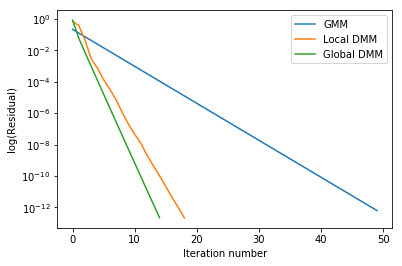

In [14]:
plt.semilogy(linear_gmg.get_gmg_convergence(),label = 'GMM')
plt.semilogy(deep_gmm.get_gmg_convergence(),label= 'Local DMM')
plt.semilogy(DMM_Res,label= 'Global DMM')
plt.xlabel("Iteration number")
plt.ylabel("log(Residual)")
plt.legend()